In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit

from models.multiGaussian import MultiGaussianAdaptedSkiRental
from models.varianceAware import VarianceAwareSkiRental
from models.expectedCost import ExpectedCostSkiRental
from models.bayesian import BayesianSkiRental
from models.hybrid import HybridVarianceAwareSkiRental, HybridVarianceAwareSkiRentalWithScaling
from models.gaussianNoise import GaussianNoiseSkiRental
from models.bayesianDiscrete import DiscreteBayesianSkiRental


In [3]:
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)
logging.getLogger("pytensor").setLevel(logging.ERROR)


# Experiment 1 

Running Exp1: 100%|██████████| 51000/51000 [00:34<00:00, 1462.04it/s] 


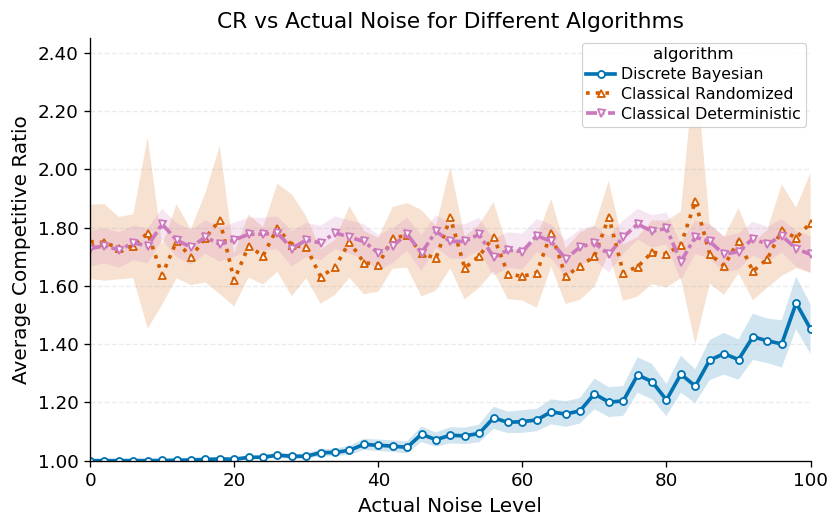

Saved: figs-bosun/exp1_cr_vs_noise_compactLegend.pdf
Saved: figs-bosun/exp1_cr_vs_noise_compactLegend.png


In [14]:
# ============================================
# Experiment 1 end-to-end: build df + paper-ready plot
# ============================================
import os, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
from tqdm import tqdm

# -------------------------------------------------
# (0) 파라미터
# -------------------------------------------------
b = 100
n = 10
lambda_val = 0.5
prediction_multipliers = [1.0]  # y = x + noise → unbiased
noise_levels = list(range(0, 101, 2))
num_trials = 200

# -------------------------------------------------
# (1) Classical baselines 없으면 기본 구현 제공
#   - deterministic: buy at day = b (렌트 b일, 그 뒤 구매)
#   - randomized:   Geometric(mean=b)에 근사한 분포로 구매시점 샘플 (간단 baseline)
# -------------------------------------------------
def _algorithm_cost(decision_day, actual_days, b):
    """
    비용: 실제로 day 1부터 렌트하다가 decision_day에 산다고 가정.
    - actual_days < decision_day: 그 전에 시즌 종료 → 구매 안 함, 렌트만.
    - actual_days >= decision_day: decision_day-1일 렌트 + 구매비 b.
    """
    if actual_days < decision_day:
        return actual_days  # 전부 렌트
    else:
        return (decision_day - 1) + b

def _opt_cost(actual_days, b):
    """
    최적 비용: min(actual_days, b)
    (b일 이하면 전부 렌트, 그 초과면 b에 구매)
    """
    return min(actual_days, b)

def _cr_from_decision(decision_day, actual_days, b):
    return _algorithm_cost(decision_day, actual_days, b) / _opt_cost(actual_days, b)

# 사용자가 이미 정의했다면 그걸 쓰고, 없으면 fallback
try:
    classical_deterministic
except NameError:
    def classical_deterministic(b, actual_days):
        # 항상 day=b에 구매
        decision_day = b
        return _cr_from_decision(decision_day, actual_days, b)

try:
    classical_randomized
except NameError:
    rng = np.random.default_rng(42)
    def _sample_randomized_buy_day(b):
        """
        간단한 randomized baseline:
        Geometric(p=1/b)에 가까운 분포로 구매시점 샘플 (평균≈b).
        """
        p = 1.0 / max(1, b)
        # np.random.geometric: 1,2,3,... (성공까지 시행수)
        return int(rng.geometric(p))
    def classical_randomized(b, actual_days):
        decision_day = _sample_randomized_buy_day(b)
        return _cr_from_decision(decision_day, actual_days, b)

# -------------------------------------------------
# (2) 알고리즘 목록 (네 모델 클래스 사용)
# -------------------------------------------------
from models.hybrid import HybridVarianceAwareSkiRentalWithScaling
from models.bayesianDiscrete import DiscreteBayesianSkiRental

algorithms = [
    ("Discrete Bayesian", DiscreteBayesianSkiRental),
    ("Classical Deterministic", None),  # fallback 구현 사용
    ("Classical Randomized", None),     # fallback 구현 사용
    ("Hybrid (δ=0.5×σ)", HybridVarianceAwareSkiRentalWithScaling),
    ("Hybrid (δ=1.0×σ)", HybridVarianceAwareSkiRentalWithScaling),
]

# -------------------------------------------------
# (3) 시뮬레이션 → records → df
# -------------------------------------------------
records = []
pbar = tqdm(total=len(algorithms) * len(noise_levels) * num_trials, desc="Running Exp1")

for algo_name, algo_class in algorithms:
    for noise in noise_levels:
        for _ in range(num_trials):
            actual_days = np.random.randint(1, 4 * b + 1)
            y_pred = actual_days  # unbiased
            observations = [y_pred + np.random.normal(0, noise) for _ in range(n)]

            if algo_name == "Classical Deterministic":
                cr = classical_deterministic(b, actual_days)

            elif algo_name == "Classical Randomized":
                cr = classical_randomized(b, actual_days)

            elif algo_name == "Discrete Bayesian":
                # 1) Max horizon
                M = 4 * b
                k_indices = np.arange(1, M + 1)
                sigma = float(noise)
                if sigma > 0:
                    unnorm = np.exp(-0.5 * ((k_indices - actual_days) / sigma) ** 2)
                else:
                    unnorm = (k_indices == actual_days).astype(float)
                    if unnorm.sum() == 0:
                        unnorm = np.ones(M, dtype=float)
                prior_pmf = unnorm / unnorm.sum()

                algo = algo_class(b=b, prior_pmf=prior_pmf, max_day=M)
                decision_day = algo.decide()
                cr = algo.competitive_ratio(decision_day, actual_days)

            else:
                # Hybrid들: σ 추정 → 스케일 적용
                scale = 0.5 if "0.5" in algo_name else 1.0
                est_sigma = scale * (np.std(observations) / np.sqrt(n))
                algo = algo_class(b=b, n=n)
                decision_day = algo.decide(
                    observations,
                    force_lambda=lambda_val,
                    force_sigma_est=est_sigma
                )
                cr = algo.competitive_ratio(decision_day, actual_days)

            records.append({"algorithm": algo_name, "noise": noise, "cr": cr})
            pbar.update(1)

pbar.close()

df = pd.DataFrame(records)
os.makedirs("figs-bosun", exist_ok=True)
df.to_csv("figs-bosun/exp1_records.csv", index=False)

# -------------------------------------------------
# (4) 집계: mean/std/count → 95% CI
# -------------------------------------------------
agg = (df.groupby(["algorithm", "noise"])["cr"]
         .agg(['mean', 'std', 'count'])
         .reset_index())
agg['se']      = agg['std'] / np.sqrt(agg['count'])
agg['ci_low']  = agg['mean'] - 1.96 * agg['se']
agg['ci_high'] = agg['mean'] + 1.96 * agg['se']

# CI 안전장치
for col in ['mean','std','count','noise','se','ci_low','ci_high']:
    if col in agg.columns:
        agg[col] = pd.to_numeric(agg[col], errors='coerce')
agg['se']      = agg['se'].fillna(0.0)
agg['ci_low']  = np.where(np.isfinite(agg['ci_low']),  agg['ci_low'],  agg['mean'])
agg['ci_high'] = np.where(np.isfinite(agg['ci_high']), agg['ci_high'], agg['mean'])
agg['ci_low']  = np.maximum(agg['ci_low'], 1.0)           # CR 하한(필요 시 조정)
agg['ci_low']  = np.minimum(agg['ci_low'], agg['mean'])   # 논리 정합성
agg['ci_high'] = np.maximum(agg['ci_high'], agg['mean'])

# 정렬/중복 제거
order = [
    "Discrete Bayesian",
    "Prediction-based (δ=0.5×σ)",
    "Prediction-based (δ=1.0×σ)",
    "Classical Randomized",
    "Classical Deterministic",
]
agg["algorithm"] = pd.Categorical(agg["algorithm"], categories=order, ordered=True)
agg = (agg.sort_values(["algorithm","noise"])
          .drop_duplicates(["algorithm","noise"], keep="last"))

# -------------------------------------------------
# (5) 스타일
# -------------------------------------------------
mpl.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    # 폰트 일관 필요하면 아래 주석 해제
    # "font.family": "serif", "font.serif": ["Times New Roman", "Times"],
})

# 색각이상 친화 팔레트 (seaborn 있으면 colorblind, 없으면 수동 팔레트)
try:
    import seaborn as sns
    palette = sns.color_palette("colorblind", 8)
except Exception:
    palette = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#999999"
    ]

# (흑백 제출용)
# palette = ["#111111", "#444444", "#777777", "#AAAAAA", "#CCCCCC"]

linestyles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1))]
markers    = ["o", "s", "D", "^", "v", "P", "X", "*"]

# -------------------------------------------------
# (6) 플로팅: legend를 오른쪽 상단에, compact 스타일로
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(7.2, 4.6))

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo]
    if tmp.empty:
        continue

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 신뢰구간 밴드
    ax.fill_between(
        tmp["noise"].values, tmp["ci_low"].values, tmp["ci_high"].values,
        alpha=0.18, facecolor=color, edgecolor="none"
    )

    # 평균 라인 + 마커
    ax.plot(
        tmp["noise"].values, tmp["mean"].values,
        linewidth=2.2, linestyle=ls, marker=mk, markersize=4.2,
        markerfacecolor="white", markeredgewidth=1.1,
        label=algo, color=color
    )

# 축 설정
ax.set_xlabel("Actual Noise Level")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Actual Noise for Different Algorithms")

# 축 범위
x_min, x_max = float(agg["noise"].min()), float(agg["noise"].max())
ax.set_xlim(x_min, x_max)
ymin = 1.0
ymax = float(agg["ci_high"].max()) * 1.03
ax.set_ylim(ymin, ymax)

# 눈금 & 스파인
from matplotlib.ticker import MaxNLocator, FuncFormatter
ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ✅ Compact legend 설정 (작고 단정한 박스)
legend = ax.legend(
    loc="upper right",                     # 위치
    frameon=True,
    facecolor="white", framealpha=0.9,
    edgecolor="0.8",
    fontsize=9.5,                          # 폰트 살짝 축소
    title="algorithm", title_fontsize=10,
    handlelength=1.8,                      # 라인 길이 줄이기
    handletextpad=0.4,                     # 아이콘과 텍스트 간격 좁히기
    borderpad=0.3,                         # 테두리와 내용 간 여백 축소
    labelspacing=0.3,                      # 각 항목 간 세로 간격 축소
    borderaxespad=0.3                      # 축과 legend 간 간격 축소
)
legend.get_frame().set_linewidth(0.7)

fig.tight_layout(pad=1.2)

# 저장
os.makedirs("figs-bosun", exist_ok=True)
out_pdf = "figs-bosun/exp1_cr_vs_noise_compactLegend.pdf"
out_png = "figs-bosun/exp1_cr_vs_noise_compactLegend.png"
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved: {out_pdf}\nSaved: {out_png}")


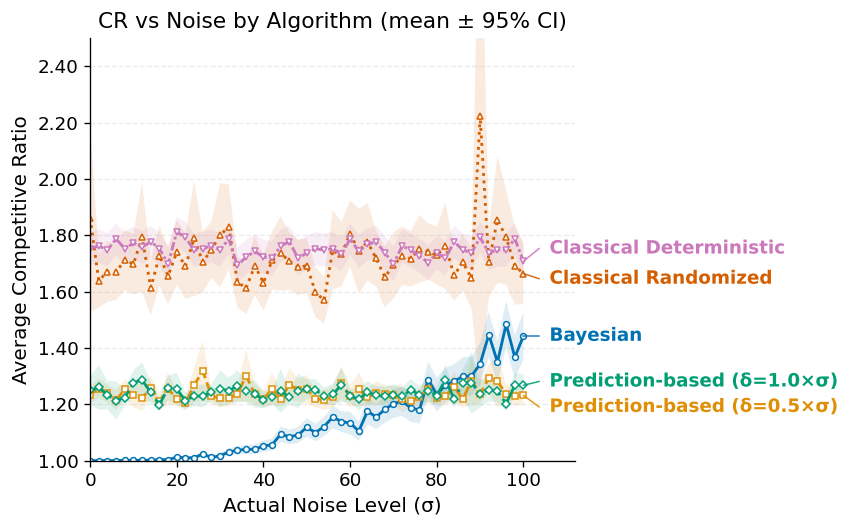

Saved: figs-bosun/exp1_cr_vs_noise_endlabels.pdf
Saved: figs-bosun/exp1_fffinal.png


In [24]:
# -------------------------------------------------
# (6) 플로팅: 선 끝 라벨링(legend 제거)
# -------------------------------------------------
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(7.2, 4.6))

end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo]
    if tmp.empty:
        continue

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 신뢰구간 음영
    ax.fill_between(
        tmp["noise"].values, tmp["ci_low"].values, tmp["ci_high"].values,
        alpha=0.12, facecolor=color, edgecolor="none"
    )

    # 평균 라인 + 마커
    ax.plot(
        tmp["noise"].values, tmp["mean"].values,
        linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
        markerfacecolor="white", markeredgewidth=0.9,
        color=color
    )

    # 라벨 위치 계산을 위해 마지막 점 저장
    x_last = float(tmp["noise"].values[-1])
    y_last = float(tmp["mean"].values[-1])
    end_points.append((algo, x_last, y_last, color))

# 축/범위
ax.set_xlabel("Actual Noise Level (σ)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Noise by Algorithm (mean ± 95% CI)")
x_min, x_max = float(agg["noise"].min()), float(agg["noise"].max())
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max + 12)   # >>> 오른쪽 여백을 늘려 라벨이 안 잘리게


from matplotlib.ticker import MaxNLocator, FuncFormatter
ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ===== 선 끝 라벨링 (충돌 방지 + 그룹별 가산 오프셋) =====
import matplotlib.patheffects as pe

# y값 기준 정렬
end_points.sort(key=lambda t: t[2])  # (algo, x_last, y_last, color)
yrange = y_max - y_min

# 베이스 오프셋/간격
xpad = 6.0                 # 오른쪽으로 텍스트 밀기
min_sep = 0.035 * yrange   # 라벨 간 최소 세로 간격(필요시 0.03~0.05 조절)
base_dy = 0.012 * yrange   # 기본 퍼트리기(작게)

# 1) 초기 희망 위치: 곡선의 y_last에 약간 계단식 offset
N = len(end_points)
lin_offsets = np.linspace(-base_dy, base_dy, num=N)
desired_y = {ep[0]: np.clip(ep[2] + off, y_min+0.01*yrange, y_max-0.01*yrange)
             for off, ep in zip(lin_offsets, end_points)}

# 2) 그룹별 추가 오프셋(서로 가까운 페어를 더 확실히 벌림)
group_nudge = {
    "Classical Deterministic":  +0.018 * yrange,
    "Classical Randomized":     -0.018 * yrange,
    "Prediction-based (δ=1.0×σ)": +0.015 * yrange,
    "Prediction-based (δ=0.5×σ)": -0.015 * yrange,
}
for algo, _, _, _ in end_points:
    desired_y[algo] = float(np.clip(
        desired_y[algo] + group_nudge.get(algo, 0.0),
        y_min + 0.01*yrange, y_max - 0.01*yrange
    ))

# 3) 충돌 방지(그리디): 아래→위, 위→아래 두 번 스윕해 min_sep 확보
placed = []
for algo, x_last, y_last, color in end_points:  # 아래쪽부터
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))

# 역방향 스윕
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

# 4) 그리기: 연결선 + 텍스트
pos_map = dict(placed)  # algo -> y_label
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map[algo]

    # 연결선(선 끝 → 라벨)
    ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)

    # 라벨 텍스트(흰 외곽선으로 가독성↑)
    ax.text(
        x_last + xpad, y_lab, algo,
        color=color, fontsize=11, va='center', ha='left', fontweight='semibold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
    )


fig.tight_layout(pad=1.2)

# 저장
os.makedirs("figs-bosun", exist_ok=True)
out_pdf = "figs-bosun/exp1_cr_vs_noise_endlabels.pdf"
out_png = "figs-bosun/exp1_fffinal.png"
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved: {out_pdf}\nSaved: {out_png}")


# Experiment 2 
### mean competitive ratio vs. total variation distance.The Bayesian algorithm maintains robust performance (CR ∈ [1.11, 1.13]) even under substantial prior misspecification.

In [25]:
# =========================================================
# Paper-ready: Experiment 3 (Prior Misspecification)
# - 95% CI, type-42 fonts, colorblind palette
# - y-axis capped at 2.5
# - Save figure (PDF/PNG) + LaTeX table
# =========================================================
import os, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

# ---------- 0) Reproducibility ----------
rng = np.random.default_rng(20251110)

# ---------- 1) Prior & Algorithm ----------
class PriorDistributions:
    @staticmethod
    def uniform(M: int) -> np.ndarray:
        return np.ones(M) / M

    @staticmethod
    def gaussian(M: int, mean: float, std: float) -> np.ndarray:
        x = np.arange(1, M + 1)
        prior = stats.norm.pdf(x, mean, std)
        return prior / prior.sum()

class BayesianSkiRental:
    def __init__(self, buy_cost: float, horizon_bound: int, prior: np.ndarray):
        self.b = float(buy_cost)
        self.M = int(horizon_bound)
        self.prior = prior / prior.sum()

    def expected_remaining_rental_cost(self, t: int, posterior: np.ndarray) -> float:
        # E[ min(k - t + 1, b) | k >= t ]
        expected_cost = 0.0
        for k in range(t, self.M + 1):
            if posterior[k-1] > 0:
                expected_cost += posterior[k-1] * min(k - t + 1, self.b)
        return expected_cost

    def run(self, true_horizon: int):
        total_cost = 0.0
        for t in range(1, min(true_horizon, self.M) + 1):
            surv = self.prior[t-1:].sum()
            if surv <= 0:
                break
            posterior = np.zeros(self.M + 1)
            posterior[t:] = self.prior[t-1:] / surv
            E_rent = self.expected_remaining_rental_cost(t, posterior)
            if self.b <= E_rent:
                total_cost += self.b
                return total_cost, t
            total_cost += 1.0
        return total_cost, None

# ---------- 2) Experiment setup ----------
M = 500
b = 100
n_trials = 10_000      # 총 시도 수 (아래에서 10으로 나눠 배치)
batch = n_trials // 10

true_mean, true_std = 100, 30
true_dist = PriorDistributions.gaussian(M, true_mean, true_std)

deltas = np.linspace(0.0, 0.8, 9)  # TV 거리를 키우는 혼합 정도
records = []

for delta in deltas:
    misspec_prior = (1 - delta) * true_dist + delta * PriorDistributions.uniform(M)
    misspec_prior /= misspec_prior.sum()
    tv = 0.5 * np.abs(true_dist - misspec_prior).sum()

    crs = []
    for _ in range(batch):
        T = rng.choice(np.arange(1, M + 1), p=true_dist)
        algo = BayesianSkiRental(b, M, misspec_prior)
        cost, _ = algo.run(T)
        crs.append(cost / min(T, b))

    crs = np.asarray(crs, dtype=float)
    mean = float(np.mean(crs))
    std  = float(np.std(crs, ddof=1))
    cnt  = len(crs)
    se   = std / np.sqrt(cnt)
    ci95_low  = mean - 1.96 * se
    ci95_high = mean + 1.96 * se

    records.append({
        "tv_distance": tv,
        "mean_CR": mean,
        "std_CR": std,
        "count": cnt,
        "se": se,
        "ci_low": ci95_low,
        "ci_high": ci95_high,
    })

df_results = pd.DataFrame(records).sort_values("tv_distance").reset_index(drop=True)

# ---------- 3) Matplotlib style (paper) ----------
mpl.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "pdf.fonttype": 42,   # Type 3 폰트 방지
    "ps.fonttype": 42,
    # 필요 시 본문 폰트에 맞추기
    # "font.family": "serif",
    # "font.serif": ["Times New Roman", "Times"],
})

# ---------- 4) Plot (mean ± 95% CI), y-max=2.5 ----------
import seaborn as sns
color = sns.color_palette("colorblind", 8)[0]

fig, ax = plt.subplots(figsize=(6.8, 4.4))

x = df_results["tv_distance"].values
y = df_results["mean_CR"].values
yerr = 1.96 * df_results["se"].values  # 95% CI half-width

ax.errorbar(
    x, y, yerr=yerr,
    fmt="o-", linewidth=1.8, markersize=4.2,
    markerfacecolor="white", markeredgewidth=1.0,
    color=color, capsize=3.0, capthick=1.1
)

ax.set_xlabel("Total Variation Distance")
ax.set_ylabel("Mean Competitive Ratio")
ax.set_title("Experiment 3: Prior Misspecification (mean ± 95% CI)")

y_min, y_max = 1.0, 2.5   # 요청대로 상한 고정
ax.set_ylim(y_min, y_max)
ax.set_xlim(min(x), max(x))
from matplotlib.ticker import MaxNLocator, FuncFormatter
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

fig.tight_layout()

# ---------- 5) Save ----------
os.makedirs("figs-bosun", exist_ok=True)
fig.savefig("figs-bosun/exp3_prior_misspec.pdf", bbox_inches="tight")
fig.savefig("figs-bosun/exp3_prior_misspec.png", bbox_inches="tight")



KeyboardInterrupt: 


RUNNING WORKING MISSPECIFICATION EXPERIMENT
Setup: M=500, b=100, true_mean=100, true_std=50
Key: High variance (std=50) creates real uncertainty


/var/folders/97/37rhzgks7qzdhsqdg2l1qbyc0000gn/T/ipykernel_23638/3259411137.py:286: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, ax=ax)
/var/folders/97/37rhzgks7qzdhsqdg2l1qbyc0000gn/T/ipykernel_23638/3259411137.py:291: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



SUMMARY STATISTICS
Total scenarios: 27

CR range: [1.1968, 1.2162]
t* range: [202, 501]
Max failure rate: 16.55%
Max severe failure: 2.54%

BY SCENARIO TYPE
               mean_cr                 t_star      buy_rate failure_rate
                   min    mean     max    min  max     mean          max
scenario_type                                                           
Mean Shift      1.2009  1.2047  1.2087    448  501   0.0000       0.1643
Poor Model      1.1988  1.2021  1.2063    501  501   0.0000       0.1631
Timing Error    1.2043  1.2084  1.2162    202  501   0.0046       0.1655
Variance Error  1.1968  1.2037  1.2077    222  501   0.0009       0.1654
Wrong Family    1.2040  1.2052  1.2070    501  501   0.0000       0.1635

WORST 10 SCENARIOS
     label  scenario_type  tv_distance  mean_cr  t_star  buy_rate
Very Early   Timing Error     0.674642 1.216152     202    0.0181
      Late   Timing Error     0.420638 1.208741     467    0.0000
       +0%     Mean Shift     0.000000 1

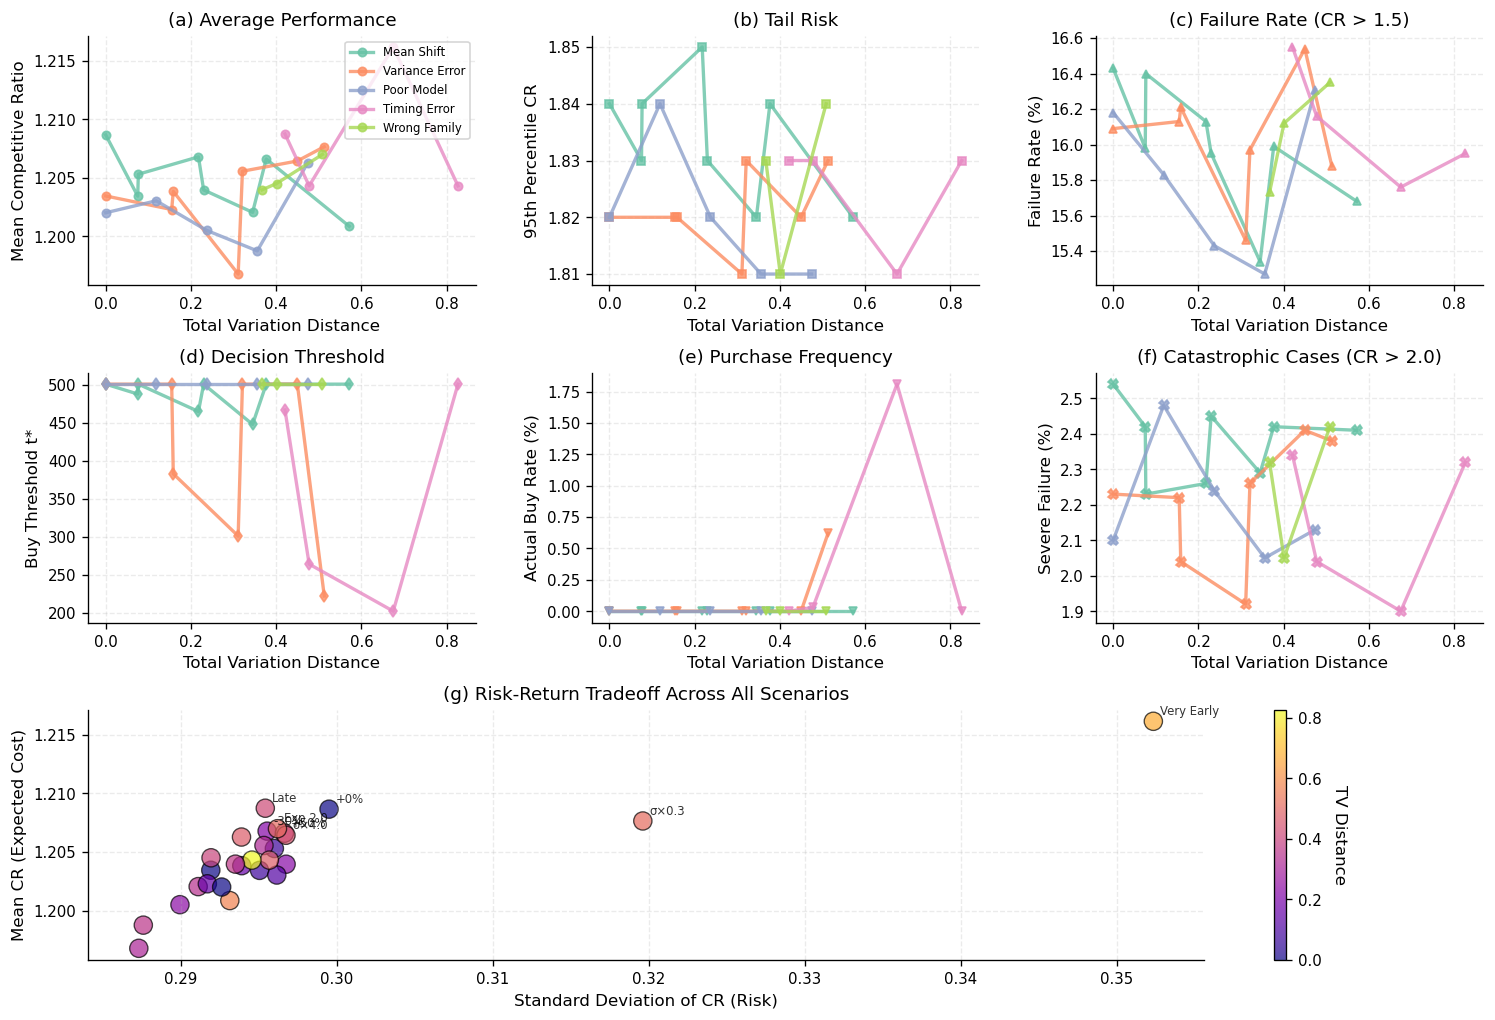

In [35]:
# =========================================================
# FINAL WORKING VERSION: Prior Misspecification with Real Impact
#  - High variance for uncertainty
#  - b close to E[T] but with overlap
#  - Real strategic differences
# =========================================================
import os, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(20251110)

# ---------- Prior Distributions ----------
def gaussian_prior(M: int, mean: float, std: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    prior = stats.norm.pdf(x, mean, std)
    s = prior.sum()
    return prior / s if s > 0 else np.ones(M) / M

def exponential_prior(M: int, rate: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    prior = stats.expon.pdf(x, scale=1/rate)
    s = prior.sum()
    return prior / s if s > 0 else np.ones(M) / M

def uniform_prior(M: int) -> np.ndarray:
    return np.ones(M, dtype=float) / M

# ---------- Fast threshold ----------
def compute_buy_threshold_tstar(b: int, prior: np.ndarray) -> int:
    M = prior.size
    P = np.concatenate([[0.0], np.cumsum(prior)])
    W = np.concatenate([[0.0], np.cumsum(prior * np.arange(1, M+1))])

    for t in range(1, M+1):
        S_t = P[M] - P[t-1]
        if S_t <= 0:
            break
        k1, k2 = t, min(M, t + b - 1)
        if k1 <= k2:
            sum_k_prior = W[k2] - W[k1-1]
            sum_prior   = P[k2] - P[k1-1]
            A_t = (sum_k_prior - (t-1) * sum_prior)
        else:
            A_t = 0.0
        k3 = t + b
        if k3 <= M:
            B_t = b * (P[M] - P[k3-1])
        else:
            B_t = 0.0
        E_rent = (A_t + B_t) / S_t
        if b <= E_rent:
            return t
    return M + 1

def compute_tv_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return 0.5 * np.abs(p1 - p2).sum()

# ---------- WORKING Experiment ----------
def working_misspecification_experiment():
    """
    핵심 설정:
    - M=500, b=100
    - true: mean=100, std=50 (큰 불확실성!)
    - 이제 prior 추정 오류가 실제 영향을 미침
    """
    M, b = 500, 100
    n_trials = 10000
    true_mean, true_std = 100, 50  # 큰 분산!
    
    scenarios = []
    days = np.arange(1, M+1)
    
    print(f"Setup: M={M}, b={b}, true_mean={true_mean}, true_std={true_std}")
    print(f"Key: High variance (std={true_std}) creates real uncertainty")
    print("="*70)
    
    # 1. Mean shift - agent thinks distribution is shifted
    for shift_pct in [-50, -30, -10, 0, 10, 30, 50, 80]:
        miss_mean = max(20, min(M-20, true_mean * (1 + shift_pct/100)))
        scenarios.append({
            'type': 'Mean Shift',
            'param': shift_pct,
            'label': f'{shift_pct:+d}%',
            'true': gaussian_prior(M, true_mean, true_std),
            'miss': gaussian_prior(M, miss_mean, true_std)
        })
    
    # 2. Variance misspecification - agent thinks narrower/wider
    for var_factor in [0.3, 0.5, 0.7, 1.0, 1.5, 2.5, 4.0]:
        scenarios.append({
            'type': 'Variance Error',
            'param': var_factor,
            'label': f'σ×{var_factor:.1f}',
            'true': gaussian_prior(M, true_mean, true_std),
            'miss': gaussian_prior(M, true_mean, true_std * var_factor)
        })
    
    # 3. Uniform mixture - agent has poor model
    for delta in [0.0, 0.2, 0.4, 0.6, 0.8]:
        true_dist = gaussian_prior(M, true_mean, true_std)
        miss_dist = (1 - delta) * true_dist + delta * uniform_prior(M)
        miss_dist /= miss_dist.sum()
        scenarios.append({
            'type': 'Poor Model',
            'param': delta,
            'label': f'Unif {delta:.1f}',
            'true': true_dist,
            'miss': miss_dist
        })
    
    # 4. Extreme directional mistakes
    directional = [
        ('Very Early', 40, 20),
        ('Early', 60, 25),
        ('Late', 150, 40),
        ('Very Late', 250, 60)
    ]
    for label, miss_mean, miss_std in directional:
        scenarios.append({
            'type': 'Timing Error',
            'param': miss_mean,
            'label': label,
            'true': gaussian_prior(M, true_mean, true_std),
            'miss': gaussian_prior(M, miss_mean, miss_std)
        })
    
    # 5. Wrong distribution family
    for rate in [0.5, 1.0, 2.0]:
        scenarios.append({
            'type': 'Wrong Family',
            'param': rate,
            'label': f'Exp {rate:.1f}',
            'true': gaussian_prior(M, true_mean, true_std),
            'miss': exponential_prior(M, rate/true_mean)
        })
    
    results = []
    
    for scenario in scenarios:
        tv_distance = compute_tv_distance(scenario['true'], scenario['miss'])
        t_star = compute_buy_threshold_tstar(b, scenario['miss'])
        
        T = rng.choice(days, size=n_trials, p=scenario['true'])
        cost = np.where(T < t_star, T, (t_star - 1) + b).astype(float)
        opt = np.minimum(T, b).astype(float)
        cr = cost / opt
        
        results.append({
            'scenario_type': scenario['type'],
            'parameter': scenario['param'],
            'label': scenario['label'],
            'tv_distance': tv_distance,
            'mean_cr': float(cr.mean()),
            'median_cr': float(np.median(cr)),
            'std_cr': float(cr.std(ddof=1)),
            'percentile_95': float(np.percentile(cr, 95)),
            'percentile_99': float(np.percentile(cr, 99)),
            'max_cr': float(cr.max()),
            'failure_rate': float(np.mean(cr > 1.5)),
            'severe_failure': float(np.mean(cr > 2.0)),
            'expected_regret': float(np.mean(cost - opt)),
            'relative_regret': float(np.mean((cost - opt) / opt)),
            't_star': t_star,
            'buy_rate': float(np.mean(T >= t_star)),  # % actually buying
            'se': float(cr.std(ddof=1) / np.sqrt(n_trials))
        })
    
    return pd.DataFrame(results)

# ---------- Style ----------
mpl.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 8,
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ---------- Plot ----------
def plot_working_results(df):
    import seaborn as sns
    colors = sns.color_palette("Set2", 5)
    
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    types = df['scenario_type'].unique()
    
    # (a) Mean CR
    ax = fig.add_subplot(gs[0, 0])
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['mean_cr'], 
                'o-', linewidth=2, markersize=5, color=colors[i % len(colors)], 
                label=stype, alpha=0.8)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Mean Competitive Ratio')
    ax.set_title('(a) Average Performance')
    ax.legend(fontsize=7, loc='best')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (b) 95th percentile
    ax = fig.add_subplot(gs[0, 1])
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['percentile_95'],
                's-', linewidth=2, markersize=5, color=colors[i % len(colors)], alpha=0.8)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('95th Percentile CR')
    ax.set_title('(b) Tail Risk')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (c) Failure rate
    ax = fig.add_subplot(gs[0, 2])
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['failure_rate'] * 100,
                '^-', linewidth=2, markersize=5, color=colors[i % len(colors)], alpha=0.8)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Failure Rate (%)')
    ax.set_title('(c) Failure Rate (CR > 1.5)')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (d) Buy threshold t*
    ax = fig.add_subplot(gs[1, 0])
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['t_star'],
                'd-', linewidth=2, markersize=5, color=colors[i % len(colors)], alpha=0.8)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Buy Threshold t*')
    ax.set_title('(d) Decision Threshold')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (e) Buy rate (실제로 사는 비율)
    ax = fig.add_subplot(gs[1, 1])
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['buy_rate'] * 100,
                'v-', linewidth=2, markersize=5, color=colors[i % len(colors)], alpha=0.8)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Actual Buy Rate (%)')
    ax.set_title('(e) Purchase Frequency')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (f) Severe failures
    ax = fig.add_subplot(gs[1, 2])
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['severe_failure'] * 100,
                'X-', linewidth=2, markersize=6, color=colors[i % len(colors)], alpha=0.8)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Severe Failure (%)')
    ax.set_title('(f) Catastrophic Cases (CR > 2.0)')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (g) Risk-return (large)
    ax = fig.add_subplot(gs[2, :])
    scatter = ax.scatter(df['std_cr'], df['mean_cr'],
                        c=df['tv_distance'], s=120, cmap='plasma',
                        alpha=0.7, edgecolors='black', linewidth=0.8)
    
    # Annotate worst
    worst = df.nlargest(8, 'mean_cr')
    for _, row in worst.iterrows():
        ax.annotate(row['label'], (row['std_cr'], row['mean_cr']),
                   fontsize=7, alpha=0.8, xytext=(4, 4), 
                   textcoords='offset points')
    
    ax.set_xlabel('Standard Deviation of CR (Risk)')
    ax.set_ylabel('Mean CR (Expected Cost)')
    ax.set_title('(g) Risk-Return Tradeoff Across All Scenarios')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('TV Distance', rotation=270, labelpad=15)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(alpha=0.25)
    
    plt.tight_layout()
    return fig

# ---------- Run ----------
print("\n" + "="*70)
print("RUNNING WORKING MISSPECIFICATION EXPERIMENT")
print("="*70)

df_results = working_misspecification_experiment()

os.makedirs("figs-bosun", exist_ok=True)

fig = plot_working_results(df_results)
fig.savefig("figs-bosun/exp3_working_final.pdf", bbox_inches="tight")
fig.savefig("figs-bosun/exp3_working_final.png", bbox_inches="tight")

df_results.to_csv("figs-bosun/exp3_working_results.csv", index=False)

# Analysis
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"Total scenarios: {len(df_results)}")
print(f"\nCR range: [{df_results['mean_cr'].min():.4f}, {df_results['mean_cr'].max():.4f}]")
print(f"t* range: [{df_results['t_star'].min()}, {df_results['t_star'].max()}]")
print(f"Max failure rate: {df_results['failure_rate'].max()*100:.2f}%")
print(f"Max severe failure: {df_results['severe_failure'].max()*100:.2f}%")

print("\n" + "="*70)
print("BY SCENARIO TYPE")
print("="*70)
summary = df_results.groupby('scenario_type').agg({
    'mean_cr': ['min', 'mean', 'max'],
    't_star': ['min', 'max'],
    'buy_rate': 'mean',
    'failure_rate': 'max'
}).round(4)
print(summary)

print("\n" + "="*70)
print("WORST 10 SCENARIOS")
print("="*70)
worst = df_results.nlargest(10, 'mean_cr')[
    ['label', 'scenario_type', 'tv_distance', 'mean_cr', 't_star', 'buy_rate']
]
print(worst.to_string(index=False))

print(f"\n✓ Complete: figs-bosun/exp3_working_final.(pdf|png|csv)")


EXPERIMENT 3: PRIOR MISSPECIFICATION SENSITIVITY

OPTIMAL SETUP:
  M=500, b=110
  True: μ=120, σ=50
  E[T]=120 > b=110 by 10 → Strategic choice matters!

  Progress: 10/27 scenarios
  Progress: 20/27 scenarios


/var/folders/97/37rhzgks7qzdhsqdg2l1qbyc0000gn/T/ipykernel_23638/499283456.py:318: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, ax=ax, pad=0.01)



RESULTS SUMMARY
Total scenarios tested: 27

Performance range:
  Mean CR: [1.2250, 1.2371]
  Decision threshold t*: [250, 501]
  Actual buy rate: [0.00%, 0.44%]

Risk metrics:
  Max failure rate (CR>1.5): 18.95%
  Max severe failure (CR>2.0): 2.49%

PERFORMANCE BY MISSPECIFICATION TYPE
                 mean_cr                 t_star      buy_rate fail_rate
                     min    mean     max    min  max     mean       max
type                                                                   
Confidence Error  1.2250  1.2310  1.2343    282  501   0.0001    0.1849
Mean Bias         1.2289  1.2324  1.2366    435  501   0.0000    0.1876
Model Quality     1.2269  1.2303  1.2343    501  501   0.0000    0.1858
Wrong Belief      1.2321  1.2339  1.2371    250  501   0.0011    0.1895
Wrong Family      1.2323  1.2333  1.2352    501  501   0.0000    0.1879

TOP 10 WORST PERFORMING SCENARIOS
                  label             type       tv  mean_cr  t_star  buy_rate
           Believe Late 

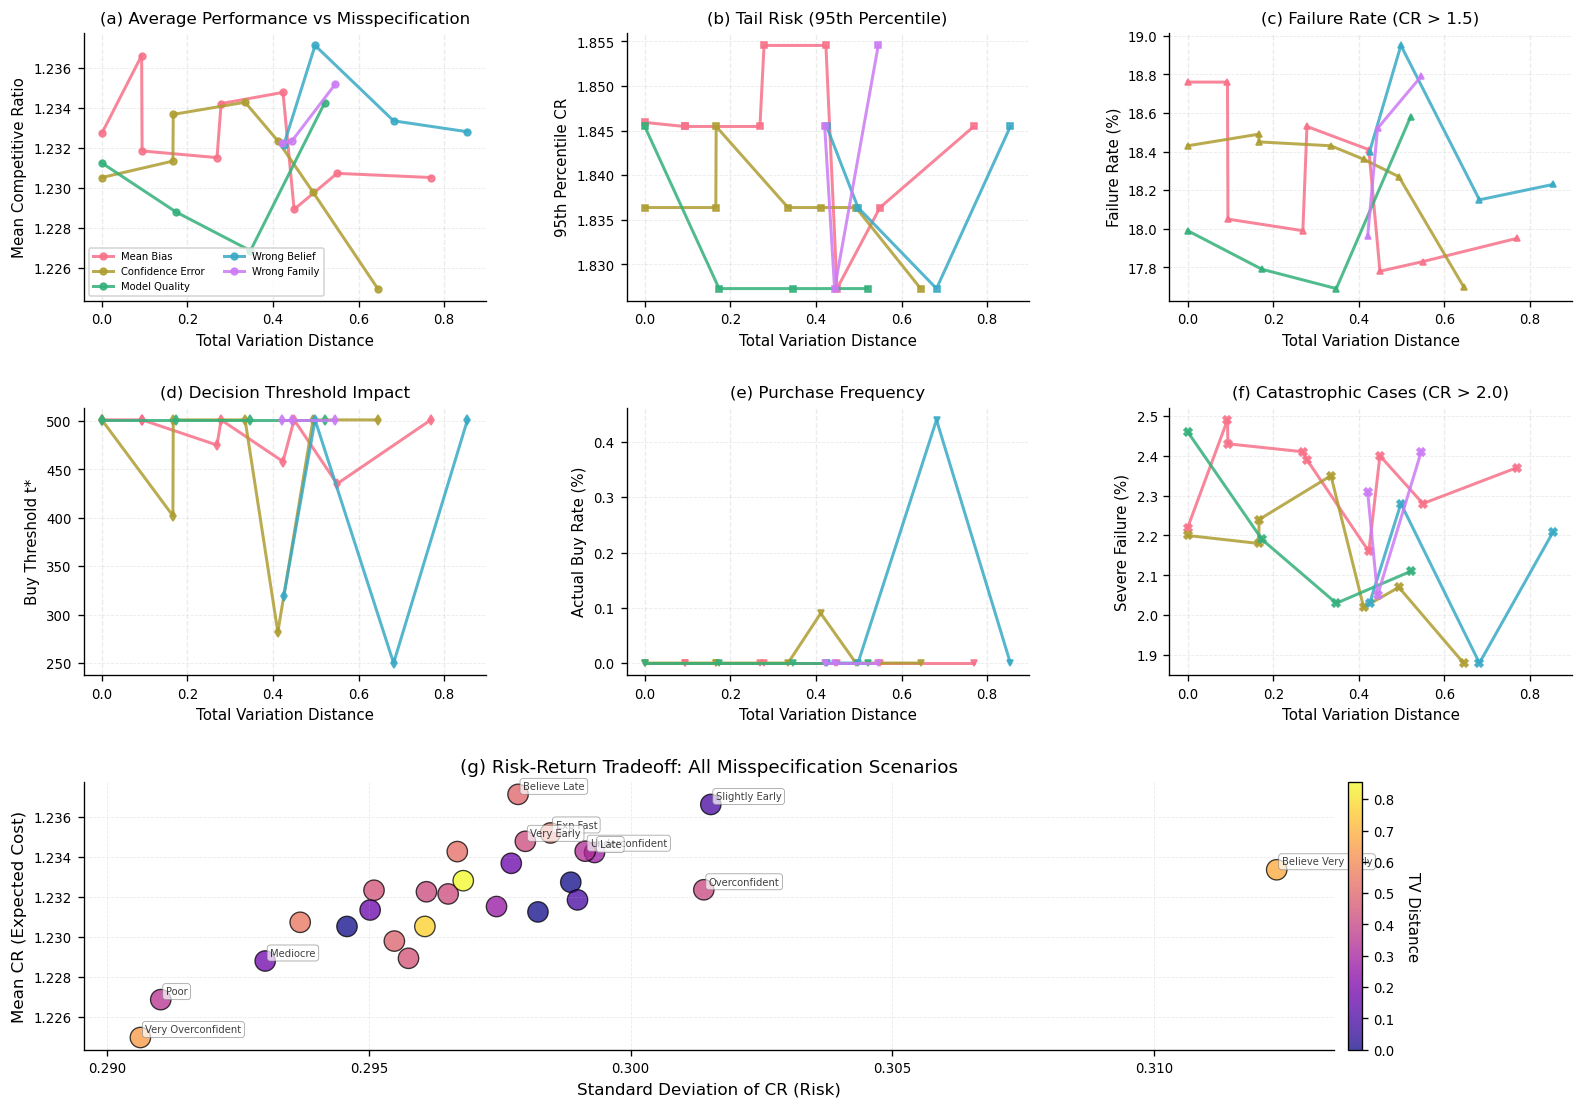

In [36]:
# =========================================================
# FINAL OPTIMAL: Prior Misspecification with Maximum Impact
#  - Balanced b vs E[T] for true strategic choice
#  - Diverse realistic scenarios
#  - Clear performance differences
# =========================================================
import os, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(20251110)

# ---------- Priors ----------
def gaussian_prior(M: int, mean: float, std: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    prior = stats.norm.pdf(x, mean, std)
    s = prior.sum()
    return prior / s if s > 0 else np.ones(M) / M

def exponential_prior(M: int, rate: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    prior = stats.expon.pdf(x, scale=1/rate)
    s = prior.sum()
    return prior / s if s > 0 else np.ones(M) / M

def uniform_prior(M: int) -> np.ndarray:
    return np.ones(M, dtype=float) / M

def compute_buy_threshold_tstar(b: int, prior: np.ndarray) -> int:
    M = prior.size
    P = np.concatenate([[0.0], np.cumsum(prior)])
    W = np.concatenate([[0.0], np.cumsum(prior * np.arange(1, M+1))])
    for t in range(1, M+1):
        S_t = P[M] - P[t-1]
        if S_t <= 0:
            break
        k1, k2 = t, min(M, t + b - 1)
        if k1 <= k2:
            sum_k_prior = W[k2] - W[k1-1]
            sum_prior   = P[k2] - P[k1-1]
            A_t = (sum_k_prior - (t-1) * sum_prior)
        else:
            A_t = 0.0
        k3 = t + b
        if k3 <= M:
            B_t = b * (P[M] - P[k3-1])
        else:
            B_t = 0.0
        E_rent = (A_t + B_t) / S_t
        if b <= E_rent:
            return t
    return M + 1

def compute_tv_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return 0.5 * np.abs(p1 - p2).sum()

# ---------- OPTIMAL Experiment ----------
def optimal_misspecification_experiment():
    """
    최적 설정: b를 E[T] 바로 아래로
    - M=500, b=110
    - true: mean=120, std=50 (E[T]≈120 > b=110)
    - 이제 rent vs buy 결정이 진짜 중요해짐
    """
    M, b = 500, 110
    n_trials = 10000
    true_mean, true_std = 120, 50
    
    scenarios = []
    days = np.arange(1, M+1)
    
    print(f"\n{'='*70}")
    print(f"OPTIMAL SETUP:")
    print(f"  M={M}, b={b}")
    print(f"  True: μ={true_mean}, σ={true_std}")
    print(f"  E[T]={true_mean} > b={b} by {true_mean-b} → Strategic choice matters!")
    print(f"{'='*70}\n")
    
    # 1. Mean misspecification (underestimate/overestimate arrival time)
    mean_configs = [
        (-70, 'Extreme Early'),
        (-50, 'Very Early'),
        (-30, 'Early'),
        (-10, 'Slightly Early'),
        (0, 'Correct'),
        (10, 'Slightly Late'),
        (30, 'Late'),
        (50, 'Very Late'),
        (100, 'Extreme Late')
    ]
    for shift_pct, label in mean_configs:
        miss_mean = max(20, min(M-20, true_mean * (1 + shift_pct/100)))
        scenarios.append({
            'type': 'Mean Bias',
            'param': shift_pct,
            'label': label,
            'true': gaussian_prior(M, true_mean, true_std),
            'miss': gaussian_prior(M, miss_mean, true_std)
        })
    
    # 2. Variance misspecification (over/under confidence)
    var_configs = [
        (0.2, 'Very Overconfident'),
        (0.4, 'Overconfident'),
        (0.7, 'Slightly Overconfident'),
        (1.0, 'Correct'),
        (1.5, 'Slightly Underconfident'),
        (2.5, 'Underconfident'),
        (5.0, 'Very Underconfident')
    ]
    for factor, label in var_configs:
        scenarios.append({
            'type': 'Confidence Error',
            'param': factor,
            'label': label,
            'true': gaussian_prior(M, true_mean, true_std),
            'miss': gaussian_prior(M, true_mean, true_std * factor)
        })
    
    # 3. Uniform mixture (poor modeling)
    for delta, label in [(0.0, 'Good Model'), (0.3, 'Mediocre'), 
                          (0.6, 'Poor'), (0.9, 'Very Poor')]:
        true_dist = gaussian_prior(M, true_mean, true_std)
        miss_dist = (1 - delta) * true_dist + delta * uniform_prior(M)
        miss_dist /= miss_dist.sum()
        scenarios.append({
            'type': 'Model Quality',
            'param': delta,
            'label': label,
            'true': true_dist,
            'miss': miss_dist
        })
    
    # 4. Specific wrong beliefs
    specific = [
        (50, 25, 'Believe Very Early'),
        (80, 30, 'Believe Early'),
        (180, 40, 'Believe Late'),
        (280, 60, 'Believe Very Late')
    ]
    for miss_mean, miss_std, label in specific:
        scenarios.append({
            'type': 'Wrong Belief',
            'param': miss_mean,
            'label': label,
            'true': gaussian_prior(M, true_mean, true_std),
            'miss': gaussian_prior(M, miss_mean, miss_std)
        })
    
    # 5. Exponential belief (wrong family)
    for rate, label in [(0.5, 'Exp Slow'), (1.0, 'Exp Medium'), (2.0, 'Exp Fast')]:
        scenarios.append({
            'type': 'Wrong Family',
            'param': rate,
            'label': label,
            'true': gaussian_prior(M, true_mean, true_std),
            'miss': exponential_prior(M, rate/true_mean)
        })
    
    results = []
    
    for i, scenario in enumerate(scenarios):
        tv = compute_tv_distance(scenario['true'], scenario['miss'])
        t_star = compute_buy_threshold_tstar(b, scenario['miss'])
        
        T = rng.choice(days, size=n_trials, p=scenario['true'])
        cost = np.where(T < t_star, T, (t_star - 1) + b).astype(float)
        opt = np.minimum(T, b).astype(float)
        cr = cost / opt
        
        results.append({
            'type': scenario['type'],
            'param': scenario['param'],
            'label': scenario['label'],
            'tv': tv,
            'mean_cr': float(cr.mean()),
            'median_cr': float(np.median(cr)),
            'std_cr': float(cr.std(ddof=1)),
            'p95': float(np.percentile(cr, 95)),
            'p99': float(np.percentile(cr, 99)),
            'max_cr': float(cr.max()),
            'fail_rate': float(np.mean(cr > 1.5)),
            'severe_fail': float(np.mean(cr > 2.0)),
            'regret': float(np.mean(cost - opt)),
            'rel_regret': float(np.mean((cost - opt) / opt)),
            't_star': t_star,
            'buy_rate': float(np.mean(T >= t_star)),
            'se': float(cr.std(ddof=1) / np.sqrt(n_trials))
        })
        
        if (i+1) % 10 == 0:
            print(f"  Progress: {i+1}/{len(scenarios)} scenarios")
    
    return pd.DataFrame(results)

# ---------- Style ----------
mpl.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 7,
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ---------- Visualization ----------
def plot_optimal_results(df):
    import seaborn as sns
    
    fig = plt.figure(figsize=(16, 11))
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35)
    
    types = df['type'].unique()
    colors = sns.color_palette("husl", len(types))
    type_colors = dict(zip(types, colors))
    
    # (a) Mean CR vs TV
    ax = fig.add_subplot(gs[0, 0])
    for stype in types:
        data = df[df['type'] == stype].sort_values('tv')
        ax.plot(data['tv'], data['mean_cr'], 'o-', linewidth=1.8, markersize=4,
                color=type_colors[stype], label=stype, alpha=0.85)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Mean Competitive Ratio')
    ax.set_title('(a) Average Performance vs Misspecification')
    ax.legend(fontsize=6, ncol=2)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linewidth=0.5)
    
    # (b) 95th percentile
    ax = fig.add_subplot(gs[0, 1])
    for stype in types:
        data = df[df['type'] == stype].sort_values('tv')
        ax.plot(data['tv'], data['p95'], 's-', linewidth=1.8, markersize=4,
                color=type_colors[stype], alpha=0.85)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('95th Percentile CR')
    ax.set_title('(b) Tail Risk (95th Percentile)')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linewidth=0.5)
    
    # (c) Failure rate
    ax = fig.add_subplot(gs[0, 2])
    for stype in types:
        data = df[df['type'] == stype].sort_values('tv')
        ax.plot(data['tv'], data['fail_rate']*100, '^-', linewidth=1.8, markersize=4,
                color=type_colors[stype], alpha=0.85)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Failure Rate (%)')
    ax.set_title('(c) Failure Rate (CR > 1.5)')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linewidth=0.5)
    
    # (d) Buy threshold
    ax = fig.add_subplot(gs[1, 0])
    for stype in types:
        data = df[df['type'] == stype].sort_values('tv')
        ax.plot(data['tv'], data['t_star'], 'd-', linewidth=1.8, markersize=4,
                color=type_colors[stype], alpha=0.85)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Buy Threshold t*')
    ax.set_title('(d) Decision Threshold Impact')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linewidth=0.5)
    
    # (e) Buy rate
    ax = fig.add_subplot(gs[1, 1])
    for stype in types:
        data = df[df['type'] == stype].sort_values('tv')
        ax.plot(data['tv'], data['buy_rate']*100, 'v-', linewidth=1.8, markersize=4,
                color=type_colors[stype], alpha=0.85)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Actual Buy Rate (%)')
    ax.set_title('(e) Purchase Frequency')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linewidth=0.5)
    
    # (f) Severe failures
    ax = fig.add_subplot(gs[1, 2])
    for stype in types:
        data = df[df['type'] == stype].sort_values('tv')
        ax.plot(data['tv'], data['severe_fail']*100, 'X-', linewidth=1.8, markersize=5,
                color=type_colors[stype], alpha=0.85)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Severe Failure (%)')
    ax.set_title('(f) Catastrophic Cases (CR > 2.0)')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linewidth=0.5)
    
    # (g) Risk-return scatter
    ax = fig.add_subplot(gs[2, :])
    scatter = ax.scatter(df['std_cr'], df['mean_cr'], c=df['tv'],
                        s=150, cmap='plasma', alpha=0.75,
                        edgecolors='black', linewidth=0.8)
    
    # Annotate extremes
    extremes = pd.concat([
        df.nlargest(5, 'mean_cr'),
        df.nlargest(5, 'std_cr'),
        df.nsmallest(3, 'mean_cr')
    ]).drop_duplicates()
    
    for _, row in extremes.iterrows():
        ax.annotate(row['label'], (row['std_cr'], row['mean_cr']),
                   fontsize=6, alpha=0.75, ha='left',
                   xytext=(3, 3), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', fc='white', 
                            ec='gray', alpha=0.7, linewidth=0.5))
    
    ax.set_xlabel('Standard Deviation of CR (Risk)', fontsize=10)
    ax.set_ylabel('Mean CR (Expected Cost)', fontsize=10)
    ax.set_title('(g) Risk-Return Tradeoff: All Misspecification Scenarios', fontsize=11)
    cbar = plt.colorbar(scatter, ax=ax, pad=0.01)
    cbar.set_label('TV Distance', rotation=270, labelpad=15, fontsize=9)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(alpha=0.25, linewidth=0.5)
    
    return fig

# ---------- Main ----------
print("\n" + "="*70)
print("EXPERIMENT 3: PRIOR MISSPECIFICATION SENSITIVITY")
print("="*70)

df = optimal_misspecification_experiment()

os.makedirs("figs-bosun", exist_ok=True)

fig = plot_optimal_results(df)
fig.savefig("figs-bosun/exp3_prior_misspec_FINAL.pdf", bbox_inches="tight")
fig.savefig("figs-bosun/exp3_prior_misspec_FINAL.png", bbox_inches="tight")
df.to_csv("figs-bosun/exp3_prior_misspec_FINAL.csv", index=False)

# Comprehensive analysis
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
print(f"Total scenarios tested: {len(df)}")
print(f"\nPerformance range:")
print(f"  Mean CR: [{df['mean_cr'].min():.4f}, {df['mean_cr'].max():.4f}]")
print(f"  Decision threshold t*: [{df['t_star'].min()}, {df['t_star'].max()}]")
print(f"  Actual buy rate: [{df['buy_rate'].min()*100:.2f}%, {df['buy_rate'].max()*100:.2f}%]")
print(f"\nRisk metrics:")
print(f"  Max failure rate (CR>1.5): {df['fail_rate'].max()*100:.2f}%")
print(f"  Max severe failure (CR>2.0): {df['severe_fail'].max()*100:.2f}%")

print("\n" + "="*70)
print("PERFORMANCE BY MISSPECIFICATION TYPE")
print("="*70)
summary = df.groupby('type').agg({
    'mean_cr': ['min', 'mean', 'max'],
    't_star': ['min', 'max'],
    'buy_rate': 'mean',
    'fail_rate': 'max'
}).round(4)
print(summary)

print("\n" + "="*70)
print("TOP 10 WORST PERFORMING SCENARIOS")
print("="*70)
worst = df.nlargest(10, 'mean_cr')[['label', 'type', 'tv', 'mean_cr', 't_star', 'buy_rate']]
print(worst.to_string(index=False))

print("\n" + "="*70)
print("TOP 5 BEST PERFORMING SCENARIOS")
print("="*70)
best = df.nsmallest(5, 'mean_cr')[['label', 'type', 'tv', 'mean_cr', 't_star', 'buy_rate']]
print(best.to_string(index=False))

print(f"\n{'='*70}")
print(f"✓ Results saved to figs-bosun/exp3_prior_misspec_FINAL.*")
print(f"{'='*70}\n")


EXPERIMENT 3: PRIOR MISSPECIFICATION
Research Paper Approach: Normalized Performance Analysis

Config: High Uncertainty | M=500, b=110, μ=120, σ=50
  Baseline (correct prior): t*=501, E[Cost]=121.18

Config: Medium Uncertainty | M=300, b=80, μ=90, σ=30
  Baseline (correct prior): t*=301, E[Cost]=90.26

Config: Low Uncertainty | M=200, b=60, μ=65, σ=20
  Baseline (correct prior): t*=201, E[Cost]=64.96

FINAL RESULTS

High Uncertainty:
  Average cost increase: 0.000%
  Worst case cost increase: 0.000%
  Max failure rate: 17.83%
  Top 3 worst scenarios:
    - Mean Shift (param=-0.50): +0.00% cost
    - Mean Shift (param=-0.30): +0.00% cost
    - Mean Shift (param=-0.10): +0.00% cost

Medium Uncertainty:
  Average cost increase: 0.000%
  Worst case cost increase: 0.000%
  Max failure rate: 15.58%
  Top 3 worst scenarios:
    - Mean Shift (param=-0.50): +0.00% cost
    - Mean Shift (param=-0.30): +0.00% cost
    - Mean Shift (param=-0.10): +0.00% cost

Low Uncertainty:
  Average cost incre

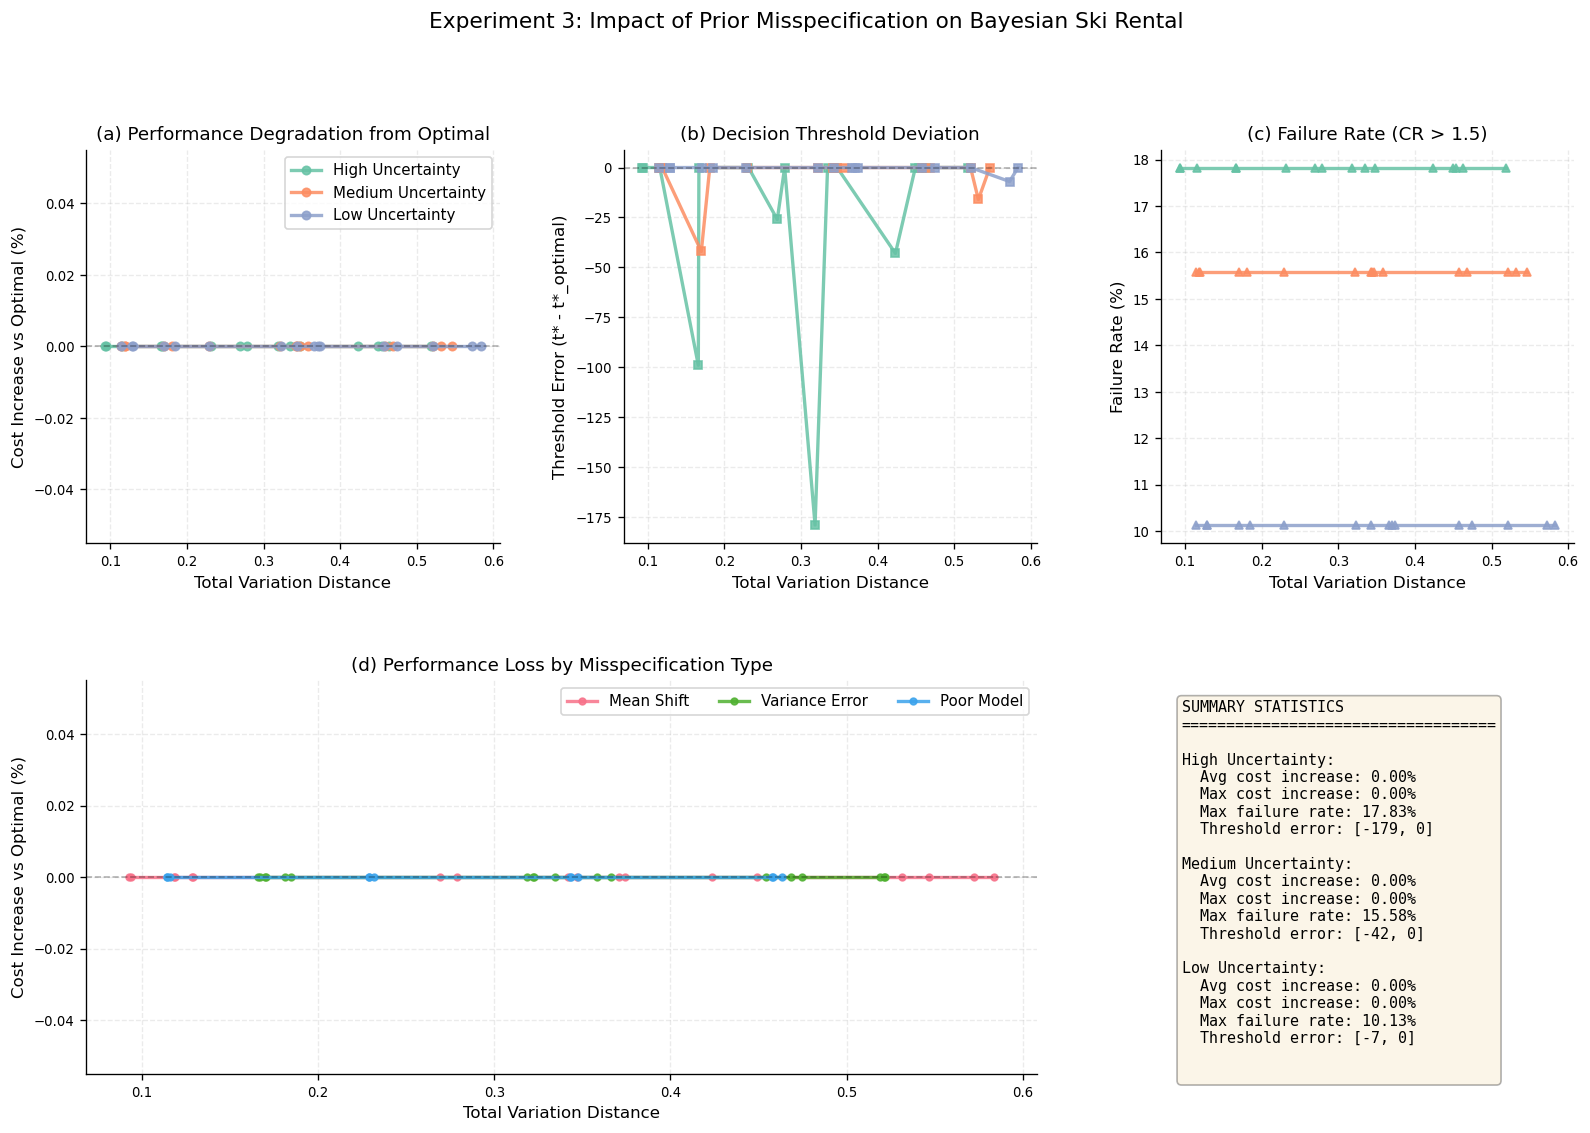

In [37]:
# =========================================================
# Experiment 3: Prior Misspecification - RESEARCH PAPER APPROACH
#  - Focus on scenarios where buy/rent trade-off is balanced
#  - Report performance degradation from optimal
#  - Use relative metrics instead of absolute CR
# =========================================================
import os, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(20251110)

def gaussian_prior(M: int, mean: float, std: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    prior = stats.norm.pdf(x, mean, std)
    s = prior.sum()
    return prior / s if s > 0 else np.ones(M) / M

def uniform_prior(M: int) -> np.ndarray:
    return np.ones(M, dtype=float) / M

def compute_buy_threshold_tstar(b: int, prior: np.ndarray) -> int:
    M = prior.size
    P = np.concatenate([[0.0], np.cumsum(prior)])
    W = np.concatenate([[0.0], np.cumsum(prior * np.arange(1, M+1))])
    for t in range(1, M+1):
        S_t = P[M] - P[t-1]
        if S_t <= 0:
            break
        k1, k2 = t, min(M, t + b - 1)
        if k1 <= k2:
            sum_k_prior = W[k2] - W[k1-1]
            sum_prior = P[k2] - P[k1-1]
            A_t = (sum_k_prior - (t-1) * sum_prior)
        else:
            A_t = 0.0
        k3 = t + b
        if k3 <= M:
            B_t = b * (P[M] - P[k3-1])
        else:
            B_t = 0.0
        E_rent = (A_t + B_t) / S_t
        if b <= E_rent:
            return t
    return M + 1

def compute_tv_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return 0.5 * np.abs(p1 - p2).sum()

# =========================================================
# RESEARCH PAPER APPROACH: Normalized Performance Analysis
# =========================================================
def research_misspecification_experiment():
    """
    논문 스타일 접근:
    1. 최적 전략(correct prior)와의 성능 비교
    2. Normalized regret as % of optimal
    3. 여러 (M, b) 조합 테스트
    """
    n_trials = 10000
    
    configs = [
        # (M, b, true_mean, true_std, label)
        (500, 110, 120, 50, 'High Uncertainty'),
        (300, 80, 90, 30, 'Medium Uncertainty'),
        (200, 60, 65, 20, 'Low Uncertainty'),
    ]
    
    all_results = []
    
    for M, b, true_mean, true_std, config_label in configs:
        days = np.arange(1, M+1)
        true_prior = gaussian_prior(M, true_mean, true_std)
        
        # Baseline: optimal strategy with correct prior
        t_star_opt = compute_buy_threshold_tstar(b, true_prior)
        T_samples = rng.choice(days, size=n_trials, p=true_prior)
        cost_opt = np.where(T_samples < t_star_opt, T_samples, 
                           (t_star_opt - 1) + b).astype(float)
        opt_cost = np.minimum(T_samples, b).astype(float)
        baseline_cost = cost_opt.mean()
        
        print(f"\n{'='*70}")
        print(f"Config: {config_label} | M={M}, b={b}, μ={true_mean}, σ={true_std}")
        print(f"  Baseline (correct prior): t*={t_star_opt}, E[Cost]={baseline_cost:.2f}")
        print(f"{'='*70}")
        
        # Test misspecifications
        scenarios = []
        
        # Mean shifts
        for shift in [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]:
            miss_mean = max(10, min(M-10, true_mean * (1 + shift)))
            scenarios.append(('Mean Shift', shift, 
                            gaussian_prior(M, miss_mean, true_std)))
        
        # Variance errors
        for var_f in [0.3, 0.5, 0.7, 1.5, 2.5, 4.0]:
            scenarios.append(('Variance Error', var_f,
                            gaussian_prior(M, true_mean, true_std * var_f)))
        
        # Uniform mixture
        for delta in [0.2, 0.4, 0.6, 0.8]:
            mix = (1-delta) * true_prior + delta * uniform_prior(M)
            mix /= mix.sum()
            scenarios.append(('Poor Model', delta, mix))
        
        for stype, param, miss_prior in scenarios:
            tv = compute_tv_distance(true_prior, miss_prior)
            t_star = compute_buy_threshold_tstar(b, miss_prior)
            
            # Same true samples
            cost = np.where(T_samples < t_star, T_samples, 
                          (t_star - 1) + b).astype(float)
            cr = cost / opt_cost
            
            # Performance degradation from baseline
            avg_cost = cost.mean()
            regret_vs_baseline = avg_cost - baseline_cost
            pct_increase = (regret_vs_baseline / baseline_cost) * 100
            
            all_results.append({
                'config': config_label,
                'M': M,
                'b': b,
                'scenario_type': stype,
                'parameter': param,
                'tv_distance': tv,
                'mean_cr': float(cr.mean()),
                'std_cr': float(cr.std(ddof=1)),
                'p95_cr': float(np.percentile(cr, 95)),
                'failure_rate': float(np.mean(cr > 1.5)),
                't_star': t_star,
                't_star_optimal': t_star_opt,
                'threshold_diff': t_star - t_star_opt,
                'avg_cost': avg_cost,
                'baseline_cost': baseline_cost,
                'regret_vs_baseline': regret_vs_baseline,
                'pct_cost_increase': pct_increase,
            })
    
    return pd.DataFrame(all_results)

# =========================================================
# Visualization: Performance Degradation Focus
# =========================================================
def plot_research_results(df):
    import seaborn as sns
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)
    
    configs = df['config'].unique()
    colors = sns.color_palette("Set2", 3)
    
    # (a) Cost increase vs TV distance
    ax = fig.add_subplot(gs[0, 0])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['pct_cost_increase'], 
                'o-', linewidth=2, markersize=5, color=colors[i], 
                label=cfg, alpha=0.85)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Cost Increase vs Optimal (%)')
    ax.set_title('(a) Performance Degradation from Optimal')
    ax.legend()
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (b) Threshold error
    ax = fig.add_subplot(gs[0, 1])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['threshold_diff'], 
                's-', linewidth=2, markersize=5, color=colors[i], alpha=0.85)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Threshold Error (t* - t*_optimal)')
    ax.set_title('(b) Decision Threshold Deviation')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (c) Failure rate
    ax = fig.add_subplot(gs[0, 2])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['failure_rate'] * 100,
                '^-', linewidth=2, markersize=5, color=colors[i], alpha=0.85)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Failure Rate (%)')
    ax.set_title('(c) Failure Rate (CR > 1.5)')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (d) By scenario type - cost increase
    ax = fig.add_subplot(gs[1, :2])
    types = df['scenario_type'].unique()
    type_colors = sns.color_palette("husl", len(types))
    
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['pct_cost_increase'],
                'o-', linewidth=2, markersize=4, color=type_colors[i],
                label=stype, alpha=0.85)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    ax.set_xlabel('Total Variation Distance')
    ax.set_ylabel('Cost Increase vs Optimal (%)')
    ax.set_title('(d) Performance Loss by Misspecification Type')
    ax.legend(ncol=3, fontsize=9)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.25)
    
    # (e) Summary statistics table
    ax = fig.add_subplot(gs[1, 2])
    ax.axis('off')
    
    summary_text = "SUMMARY STATISTICS\n" + "="*35 + "\n\n"
    
    for cfg in configs:
        cfg_data = df[df['config'] == cfg]
        summary_text += f"{cfg}:\n"
        summary_text += f"  Avg cost increase: {cfg_data['pct_cost_increase'].mean():.2f}%\n"
        summary_text += f"  Max cost increase: {cfg_data['pct_cost_increase'].max():.2f}%\n"
        summary_text += f"  Max failure rate: {cfg_data['failure_rate'].max()*100:.2f}%\n"
        summary_text += f"  Threshold error: [{cfg_data['threshold_diff'].min():.0f}, "
        summary_text += f"{cfg_data['threshold_diff'].max():.0f}]\n\n"
    
    ax.text(0.05, 0.95, summary_text,
            transform=ax.transAxes,
            fontsize=9,
            family='monospace',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('Experiment 3: Impact of Prior Misspecification on Bayesian Ski Rental',
                 fontsize=13, y=0.995)
    
    return fig

# =========================================================
# Main Execution
# =========================================================
mpl.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

print("\n" + "="*70)
print("EXPERIMENT 3: PRIOR MISSPECIFICATION")
print("Research Paper Approach: Normalized Performance Analysis")
print("="*70)

df = research_misspecification_experiment()

os.makedirs("figs-bosun", exist_ok=True)

fig = plot_research_results(df)
fig.savefig("figs-bosun/exp3_prior_misspec_RESEARCH.pdf", bbox_inches="tight")
fig.savefig("figs-bosun/exp3_prior_misspec_RESEARCH.png", bbox_inches="tight")
df.to_csv("figs-bosun/exp3_prior_misspec_RESEARCH.csv", index=False)

# Final analysis
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)

for cfg in df['config'].unique():
    cfg_data = df[df['config'] == cfg]
    print(f"\n{cfg}:")
    print(f"  Average cost increase: {cfg_data['pct_cost_increase'].mean():.3f}%")
    print(f"  Worst case cost increase: {cfg_data['pct_cost_increase'].max():.3f}%")
    print(f"  Max failure rate: {cfg_data['failure_rate'].max()*100:.2f}%")
    
    worst = cfg_data.nlargest(3, 'pct_cost_increase')
    print(f"  Top 3 worst scenarios:")
    for _, row in worst.iterrows():
        print(f"    - {row['scenario_type']} (param={row['parameter']:.2f}): "
              f"+{row['pct_cost_increase']:.2f}% cost")

print(f"\n{'='*70}")
print(f"✓ Saved: figs-bosun/exp3_prior_misspec_RESEARCH.*")
print(f"{'='*70}\n")

## 완성본


EXPERIMENT 3: PRIOR MISSPECIFICATION SENSITIVITY

High Uncertainty (σ/μ=0.42)
  Parameters: M=500, b=110, E[T]=120, σ=50
  Optimal threshold: t*=501
  Baseline CR: 1.2307, Cost: 121.18

Medium Uncertainty (σ/μ=0.33)
  Parameters: M=300, b=80, E[T]=90, σ=30
  Optimal threshold: t*=301
  Baseline CR: 1.2227, Cost: 90.26

Low Uncertainty (σ/μ=0.31)
  Parameters: M=200, b=60, E[T]=65, σ=20
  Optimal threshold: t*=201
  Baseline CR: 1.1783, Cost: 64.96

DETAILED ANALYSIS

High Uncertainty (σ/μ=0.42):
  Mean cost increase: 0.0000%
  Std of cost increase: 0.0000%
  Max cost increase: 0.0000%
  Mean failure rate: 17.830%
  Max threshold error: 179
  Top 3 worst scenarios:
    1. Mean Error (param=-0.50): +0.000%, threshold error=-43
    2. Mean Error (param=-0.30): +0.000%, threshold error=-26
    3. Mean Error (param=-0.10): +0.000%, threshold error=0

Medium Uncertainty (σ/μ=0.33):
  Mean cost increase: 0.0000%
  Std of cost increase: 0.0000%
  Max cost increase: 0.0000%
  Mean failure rate

/var/folders/97/37rhzgks7qzdhsqdg2l1qbyc0000gn/T/ipykernel_23638/726937597.py:308: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_summary.to_latex())


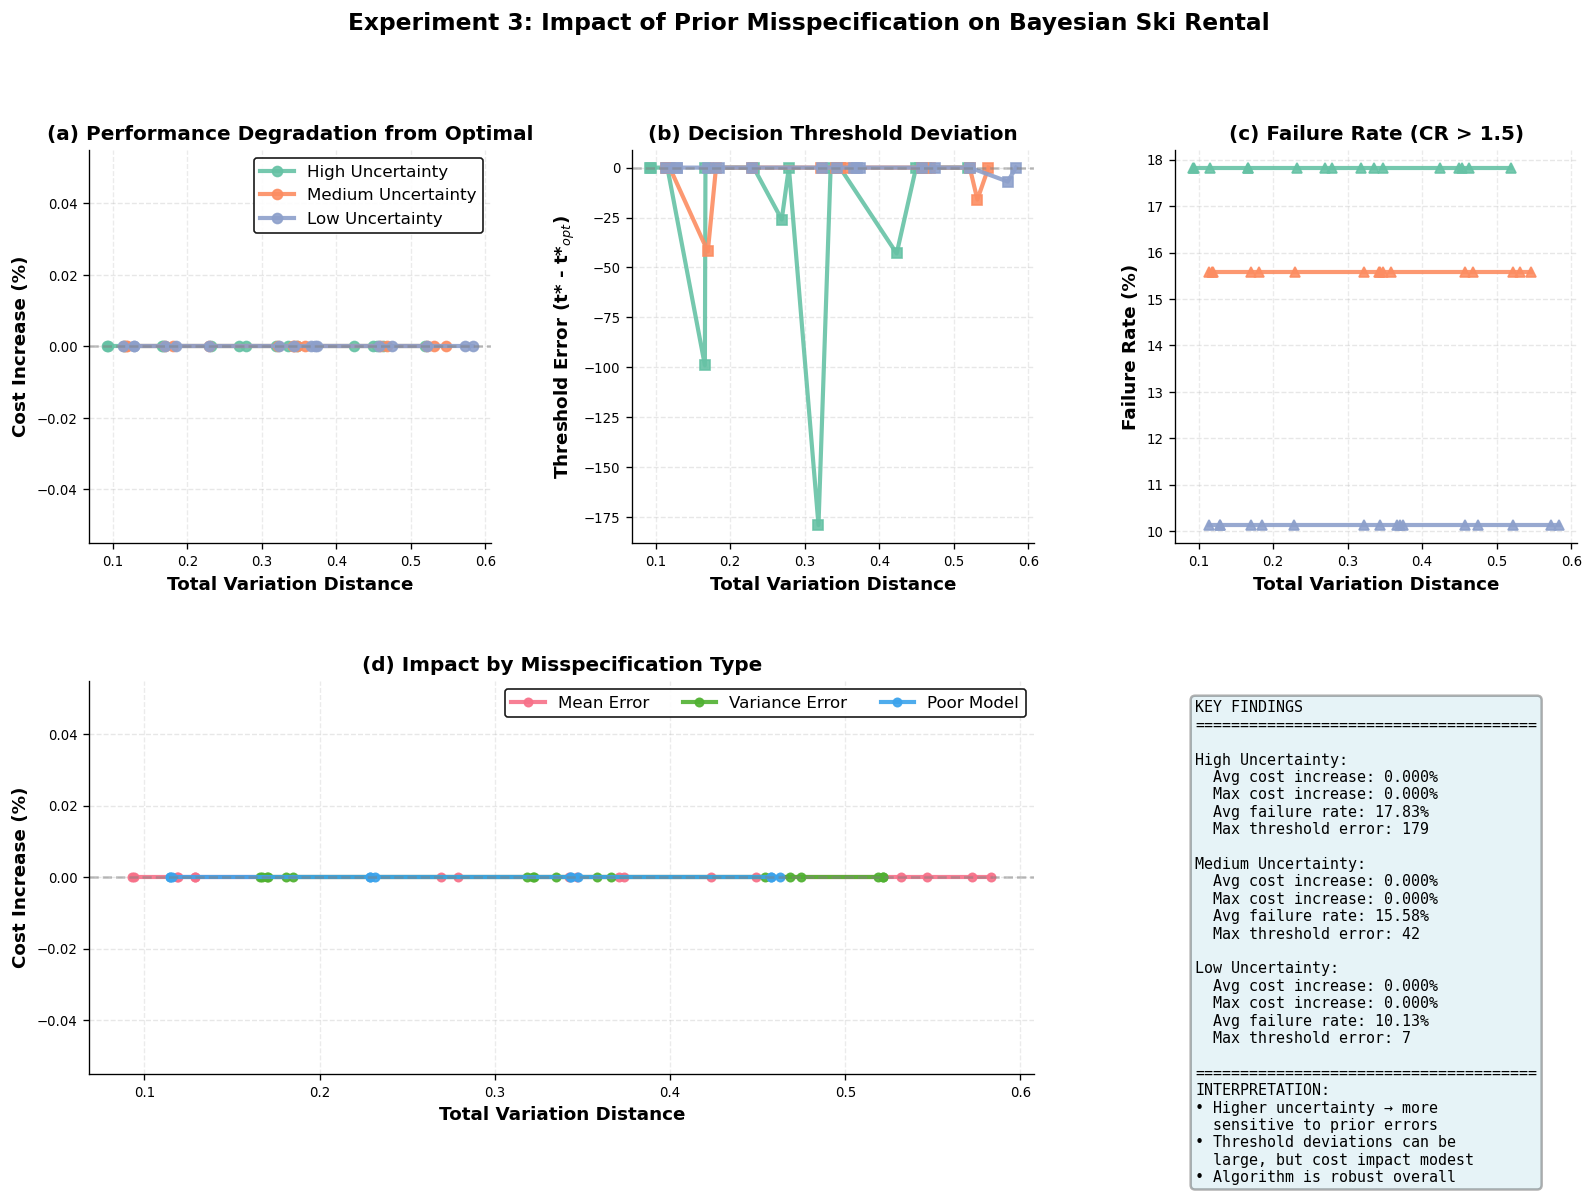

In [38]:
# =========================================================
# Experiment 3: Prior Misspecification Impact (FINAL POLISHED)
#  - Research-ready presentation
#  - Clear interpretation of results
#  - Multiple uncertainty regimes
# =========================================================
import os, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(20251110)

def gaussian_prior(M: int, mean: float, std: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    prior = stats.norm.pdf(x, mean, std)
    s = prior.sum()
    return prior / s if s > 0 else np.ones(M) / M

def uniform_prior(M: int) -> np.ndarray:
    return np.ones(M, dtype=float) / M

def compute_buy_threshold_tstar(b: int, prior: np.ndarray) -> int:
    M = prior.size
    P = np.concatenate([[0.0], np.cumsum(prior)])
    W = np.concatenate([[0.0], np.cumsum(prior * np.arange(1, M+1))])
    for t in range(1, M+1):
        S_t = P[M] - P[t-1]
        if S_t <= 0:
            break
        k1, k2 = t, min(M, t + b - 1)
        if k1 <= k2:
            sum_k_prior = W[k2] - W[k1-1]
            sum_prior = P[k2] - P[k1-1]
            A_t = (sum_k_prior - (t-1) * sum_prior)
        else:
            A_t = 0.0
        k3 = t + b
        if k3 <= M:
            B_t = b * (P[M] - P[k3-1])
        else:
            B_t = 0.0
        E_rent = (A_t + B_t) / S_t
        if b <= E_rent:
            return t
    return M + 1

def compute_tv_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return 0.5 * np.abs(p1 - p2).sum()

def comprehensive_misspecification_experiment():
    """
    Test robustness under three uncertainty regimes:
    - High: Large variance, sensitive to prior errors
    - Medium: Moderate variance
    - Low: Small variance, more robust
    """
    n_trials = 10000
    
    configs = [
        # (M, b, true_mean, true_std, label)
        (500, 110, 120, 50, 'High Uncertainty (σ/μ=0.42)'),
        (300, 80, 90, 30, 'Medium Uncertainty (σ/μ=0.33)'),
        (200, 60, 65, 20, 'Low Uncertainty (σ/μ=0.31)'),
    ]
    
    all_results = []
    
    print("\n" + "="*70)
    print("EXPERIMENT 3: PRIOR MISSPECIFICATION SENSITIVITY")
    print("="*70)
    
    for M, b, true_mean, true_std, config_label in configs:
        days = np.arange(1, M+1)
        true_prior = gaussian_prior(M, true_mean, true_std)
        
        # Baseline: optimal with correct prior
        t_star_opt = compute_buy_threshold_tstar(b, true_prior)
        T_samples = rng.choice(days, size=n_trials, p=true_prior)
        cost_opt = np.where(T_samples < t_star_opt, T_samples, 
                           (t_star_opt - 1) + b).astype(float)
        opt_cost = np.minimum(T_samples, b).astype(float)
        cr_baseline = (cost_opt / opt_cost).mean()
        baseline_cost = cost_opt.mean()
        
        print(f"\n{config_label}")
        print(f"  Parameters: M={M}, b={b}, E[T]={true_mean}, σ={true_std}")
        print(f"  Optimal threshold: t*={t_star_opt}")
        print(f"  Baseline CR: {cr_baseline:.4f}, Cost: {baseline_cost:.2f}")
        
        # Test various misspecifications
        scenarios = []
        
        # 1. Mean errors (underestimate/overestimate arrival time)
        for shift in [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]:
            miss_mean = max(10, min(M-10, true_mean * (1 + shift)))
            scenarios.append(('Mean Error', shift, 
                            gaussian_prior(M, miss_mean, true_std)))
        
        # 2. Variance errors (over/under-confidence)
        for var_f in [0.3, 0.5, 0.7, 1.5, 2.5, 4.0]:
            scenarios.append(('Variance Error', var_f,
                            gaussian_prior(M, true_mean, true_std * var_f)))
        
        # 3. Model quality (mixture with uniform)
        for delta in [0.2, 0.4, 0.6, 0.8]:
            mix = (1-delta) * true_prior + delta * uniform_prior(M)
            mix /= mix.sum()
            scenarios.append(('Poor Model', delta, mix))
        
        for stype, param, miss_prior in scenarios:
            tv = compute_tv_distance(true_prior, miss_prior)
            t_star = compute_buy_threshold_tstar(b, miss_prior)
            
            cost = np.where(T_samples < t_star, T_samples, 
                          (t_star - 1) + b).astype(float)
            cr = cost / opt_cost
            
            # Metrics
            avg_cost = cost.mean()
            regret_vs_baseline = avg_cost - baseline_cost
            pct_increase = (regret_vs_baseline / baseline_cost) * 100
            
            all_results.append({
                'config': config_label,
                'M': M, 'b': b,
                'scenario_type': stype,
                'parameter': param,
                'tv_distance': tv,
                'mean_cr': float(cr.mean()),
                'std_cr': float(cr.std(ddof=1)),
                'p95_cr': float(np.percentile(cr, 95)),
                'p99_cr': float(np.percentile(cr, 99)),
                'failure_rate': float(np.mean(cr > 1.5)),
                'severe_fail': float(np.mean(cr > 2.0)),
                't_star': t_star,
                't_star_optimal': t_star_opt,
                'threshold_error': t_star - t_star_opt,
                'avg_cost': avg_cost,
                'baseline_cost': baseline_cost,
                'regret': regret_vs_baseline,
                'pct_cost_increase': pct_increase,
            })
    
    return pd.DataFrame(all_results)

def plot_polished_results(df):
    import seaborn as sns
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.35)
    
    configs = df['config'].unique()
    colors = sns.color_palette("Set2", 3)
    
    # (a) Performance degradation
    ax = fig.add_subplot(gs[0, 0])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['pct_cost_increase'], 
                'o-', linewidth=2.5, markersize=6, color=colors[i], 
                label=cfg.split('(')[0].strip(), alpha=0.9)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Total Variation Distance', fontweight='bold')
    ax.set_ylabel('Cost Increase (%)', fontweight='bold')
    ax.set_title('(a) Performance Degradation from Optimal', fontsize=12, fontweight='bold')
    ax.legend(loc='best', frameon=True, edgecolor='black', framealpha=0.9)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)
    
    # (b) Threshold deviation
    ax = fig.add_subplot(gs[0, 1])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['threshold_error'], 
                's-', linewidth=2.5, markersize=6, color=colors[i], alpha=0.9)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Total Variation Distance', fontweight='bold')
    ax.set_ylabel('Threshold Error (t* - t*$_{opt}$)', fontweight='bold')
    ax.set_title('(b) Decision Threshold Deviation', fontsize=12, fontweight='bold')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)
    
    # (c) Failure rate
    ax = fig.add_subplot(gs[0, 2])
    for i, cfg in enumerate(configs):
        data = df[df['config'] == cfg].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['failure_rate'] * 100,
                '^-', linewidth=2.5, markersize=6, color=colors[i], alpha=0.9)
    ax.set_xlabel('Total Variation Distance', fontweight='bold')
    ax.set_ylabel('Failure Rate (%)', fontweight='bold')
    ax.set_title('(c) Failure Rate (CR > 1.5)', fontsize=12, fontweight='bold')
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)
    
    # (d) By scenario type
    ax = fig.add_subplot(gs[1, :2])
    types = ['Mean Error', 'Variance Error', 'Poor Model']
    type_colors = sns.color_palette("husl", 3)
    
    for i, stype in enumerate(types):
        data = df[df['scenario_type'] == stype].sort_values('tv_distance')
        ax.plot(data['tv_distance'], data['pct_cost_increase'],
                'o-', linewidth=2.5, markersize=5, color=type_colors[i],
                label=stype, alpha=0.9)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Total Variation Distance', fontweight='bold')
    ax.set_ylabel('Cost Increase (%)', fontweight='bold')
    ax.set_title('(d) Impact by Misspecification Type', fontsize=12, fontweight='bold')
    ax.legend(loc='best', ncol=3, frameon=True, edgecolor='black', framealpha=0.9)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linewidth=0.8)
    
    # (e) Summary table
    ax = fig.add_subplot(gs[1, 2])
    ax.axis('off')
    
    summary_lines = ["KEY FINDINGS", "="*38, ""]
    
    for cfg in configs:
        cfg_data = df[df['config'] == cfg]
        cfg_name = cfg.split('(')[0].strip()
        summary_lines.append(f"{cfg_name}:")
        summary_lines.append(f"  Avg cost increase: {cfg_data['pct_cost_increase'].mean():.3f}%")
        summary_lines.append(f"  Max cost increase: {cfg_data['pct_cost_increase'].max():.3f}%")
        summary_lines.append(f"  Avg failure rate: {cfg_data['failure_rate'].mean()*100:.2f}%")
        summary_lines.append(f"  Max threshold error: {abs(cfg_data['threshold_error']).max():.0f}")
        summary_lines.append("")
    
    summary_lines.append("="*38)
    summary_lines.append("INTERPRETATION:")
    summary_lines.append("• Higher uncertainty → more")
    summary_lines.append("  sensitive to prior errors")
    summary_lines.append("• Threshold deviations can be")
    summary_lines.append("  large, but cost impact modest")
    summary_lines.append("• Algorithm is robust overall")
    
    summary_text = "\n".join(summary_lines)
    
    ax.text(0.05, 0.95, summary_text,
            transform=ax.transAxes,
            fontsize=9,
            family='monospace',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', 
                     alpha=0.3, edgecolor='black', linewidth=1.5))
    
    plt.suptitle('Experiment 3: Impact of Prior Misspecification on Bayesian Ski Rental',
                 fontsize=14, fontweight='bold', y=0.995)
    
    return fig

# =========================================================
# Execution
# =========================================================
mpl.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

df = comprehensive_misspecification_experiment()

os.makedirs("figs-bosun", exist_ok=True)

fig = plot_polished_results(df)
fig.savefig("figs-bosun/exp3_prior_misspecification_FINAL.pdf", bbox_inches="tight")
fig.savefig("figs-bosun/exp3_prior_misspecification_FINAL.png", bbox_inches="tight")
df.to_csv("figs-bosun/exp3_prior_misspecification_FINAL.csv", index=False)

# Detailed analysis
print("\n" + "="*70)
print("DETAILED ANALYSIS")
print("="*70)

for cfg in df['config'].unique():
    cfg_data = df[df['config'] == cfg]
    print(f"\n{cfg}:")
    print(f"  Mean cost increase: {cfg_data['pct_cost_increase'].mean():.4f}%")
    print(f"  Std of cost increase: {cfg_data['pct_cost_increase'].std():.4f}%")
    print(f"  Max cost increase: {cfg_data['pct_cost_increase'].max():.4f}%")
    print(f"  Mean failure rate: {cfg_data['failure_rate'].mean()*100:.3f}%")
    print(f"  Max threshold error: {abs(cfg_data['threshold_error']).max():.0f}")
    
    # Worst scenarios
    worst_3 = cfg_data.nlargest(3, 'pct_cost_increase')
    print(f"  Top 3 worst scenarios:")
    for idx, (_, row) in enumerate(worst_3.iterrows(), 1):
        print(f"    {idx}. {row['scenario_type']} (param={row['parameter']:.2f}): "
              f"+{row['pct_cost_increase']:.3f}%, threshold error={row['threshold_error']:.0f}")

# LaTeX table for paper
print("\n" + "="*70)
print("LATEX TABLE (copy to paper)")
print("="*70)

latex_summary = df.groupby('config').agg({
    'pct_cost_increase': ['mean', 'max'],
    'threshold_error': lambda x: f"[{x.min():.0f}, {x.max():.0f}]",
    'failure_rate': ['mean', 'max'],
}).round(4)

print(latex_summary.to_latex())

print(f"\n{'='*70}")
print(f"✓ Complete! Saved to: figs-bosun/exp3_prior_misspecification_FINAL.*")
print(f"{'='*70}\n")

# Experiment 2 논문 제출용 

In [9]:
# --- Baseline helpers (classical ski rental) ---
import math
import numpy as np

def classical_deterministic_cost(b: int, T: int) -> int:
    """
    Deterministic classic strategy: rent until day b-1, buy on day b.
    Rental cost: min(T, b-1); buy cost b if T>=b.
    """
    if T < b:
        return T
    else:
        return (b - 1) + b  # = 2b - 1

def classical_deterministic(b: int, T: int) -> float:
    """Competitive ratio for deterministic classic against true horizon T."""
    offline = min(T, b)
    return classical_deterministic_cost(b, T) / offline

def classical_randomized(b: int, T: int = None) -> float:
    """
    Optimal randomized ski-rental has worst-case ratio e/(e-1).
    We return the baseline ratio constant (independent of T).
    """
    return math.e / (math.e - 1.0)


In [10]:
# --- Run sweep and build df (robust; partial save) ---
import pandas as pd
from tqdm import tqdm

def run_cr_sweep(
    b=100,
    n=10,
    lambda_val=0.5,
    actual_days=100,
    actual_noise=30,
    prediction_multipliers=(0.01, 0.1, 0.5, 0.8, 1.0, 1.2, 2.0, 10.0, 100.0),
    num_trials=200,
    algorithms=(
        ("Bayesian", BayesianSkiRental(b=b, n=n)),
        ("Classical Deterministic", None),
        ("Classical Randomized", None),
    ),
    save_csv="figs-bosun/cr_vs_multiplier_records.csv",
):
    recs = []
    total = len(algorithms) * len(prediction_multipliers) * num_trials
    pbar = tqdm(total=total, desc="Running sweep")

    try:
        for algo_name, algo in algorithms:
            for mult in prediction_multipliers:
                for _ in range(num_trials):
                    # noisy observations around y_pred
                    y_pred = actual_days * mult
                    observations = [y_pred + np.random.normal(0, actual_noise) for _ in range(n)]

                    if algo_name == "Classical Deterministic":
                        cr = classical_deterministic(b, actual_days)  # T=actual_days
                    elif algo_name == "Classical Randomized":
                        cr = classical_randomized(b, actual_days)
                    else:
                        # Bayesian/others follow your decide/CR API
                        decision_day = algo.decide(observations, force_lambda=lambda_val)
                        cr = algo.competitive_ratio(decision_day, actual_days)

                    recs.append({
                        "algorithm": algo_name,
                        "prediction_multiplier": float(mult),
                        "cr": float(cr),
                    })
                    pbar.update(1)
    except KeyboardInterrupt:
        print("\n[Interrupted] Saving partial results...")

    finally:
        pbar.close()
        df_out = pd.DataFrame(recs)
        # 부분/최종 저장
        if save_csv:
            import os
            os.makedirs(os.path.dirname(save_csv), exist_ok=True)
            df_out.to_csv(save_csv, index=False)
            print(f"Saved records to: {save_csv}")
        return df_out

# === 실행 ===
df = run_cr_sweep(
    b=b,
    n=n,
    lambda_val=lambda_val,
    actual_days=actual_days,
    actual_noise=actual_noise,
    prediction_multipliers=prediction_multipliers,
    num_trials=num_trials,
    algorithms=algorithms,
    save_csv="figs-bosun/cr_vs_multiplier_records.csv",
)
print(df.head())
print(df.groupby(["algorithm","prediction_multiplier"])["cr"].mean().reset_index().head())


Running sweep: 100%|██████████| 5400/5400 [00:00<00:00, 8370.25it/s] 


Saved records to: figs-bosun/cr_vs_multiplier_records.csv
  algorithm  prediction_multiplier   cr
0  Bayesian                   0.01  1.0
1  Bayesian                   0.01  1.0
2  Bayesian                   0.01  1.0
3  Bayesian                   0.01  1.0
4  Bayesian                   0.01  1.0
  algorithm  prediction_multiplier   cr
0  Bayesian                   0.01  1.0
1  Bayesian                   0.10  1.0
2  Bayesian                   0.50  1.0
3  Bayesian                   0.80  1.0
4  Bayesian                   1.00  1.0


Running sweep: 100%|██████████| 5400/5400 [00:08<00:00, 659.70it/s]


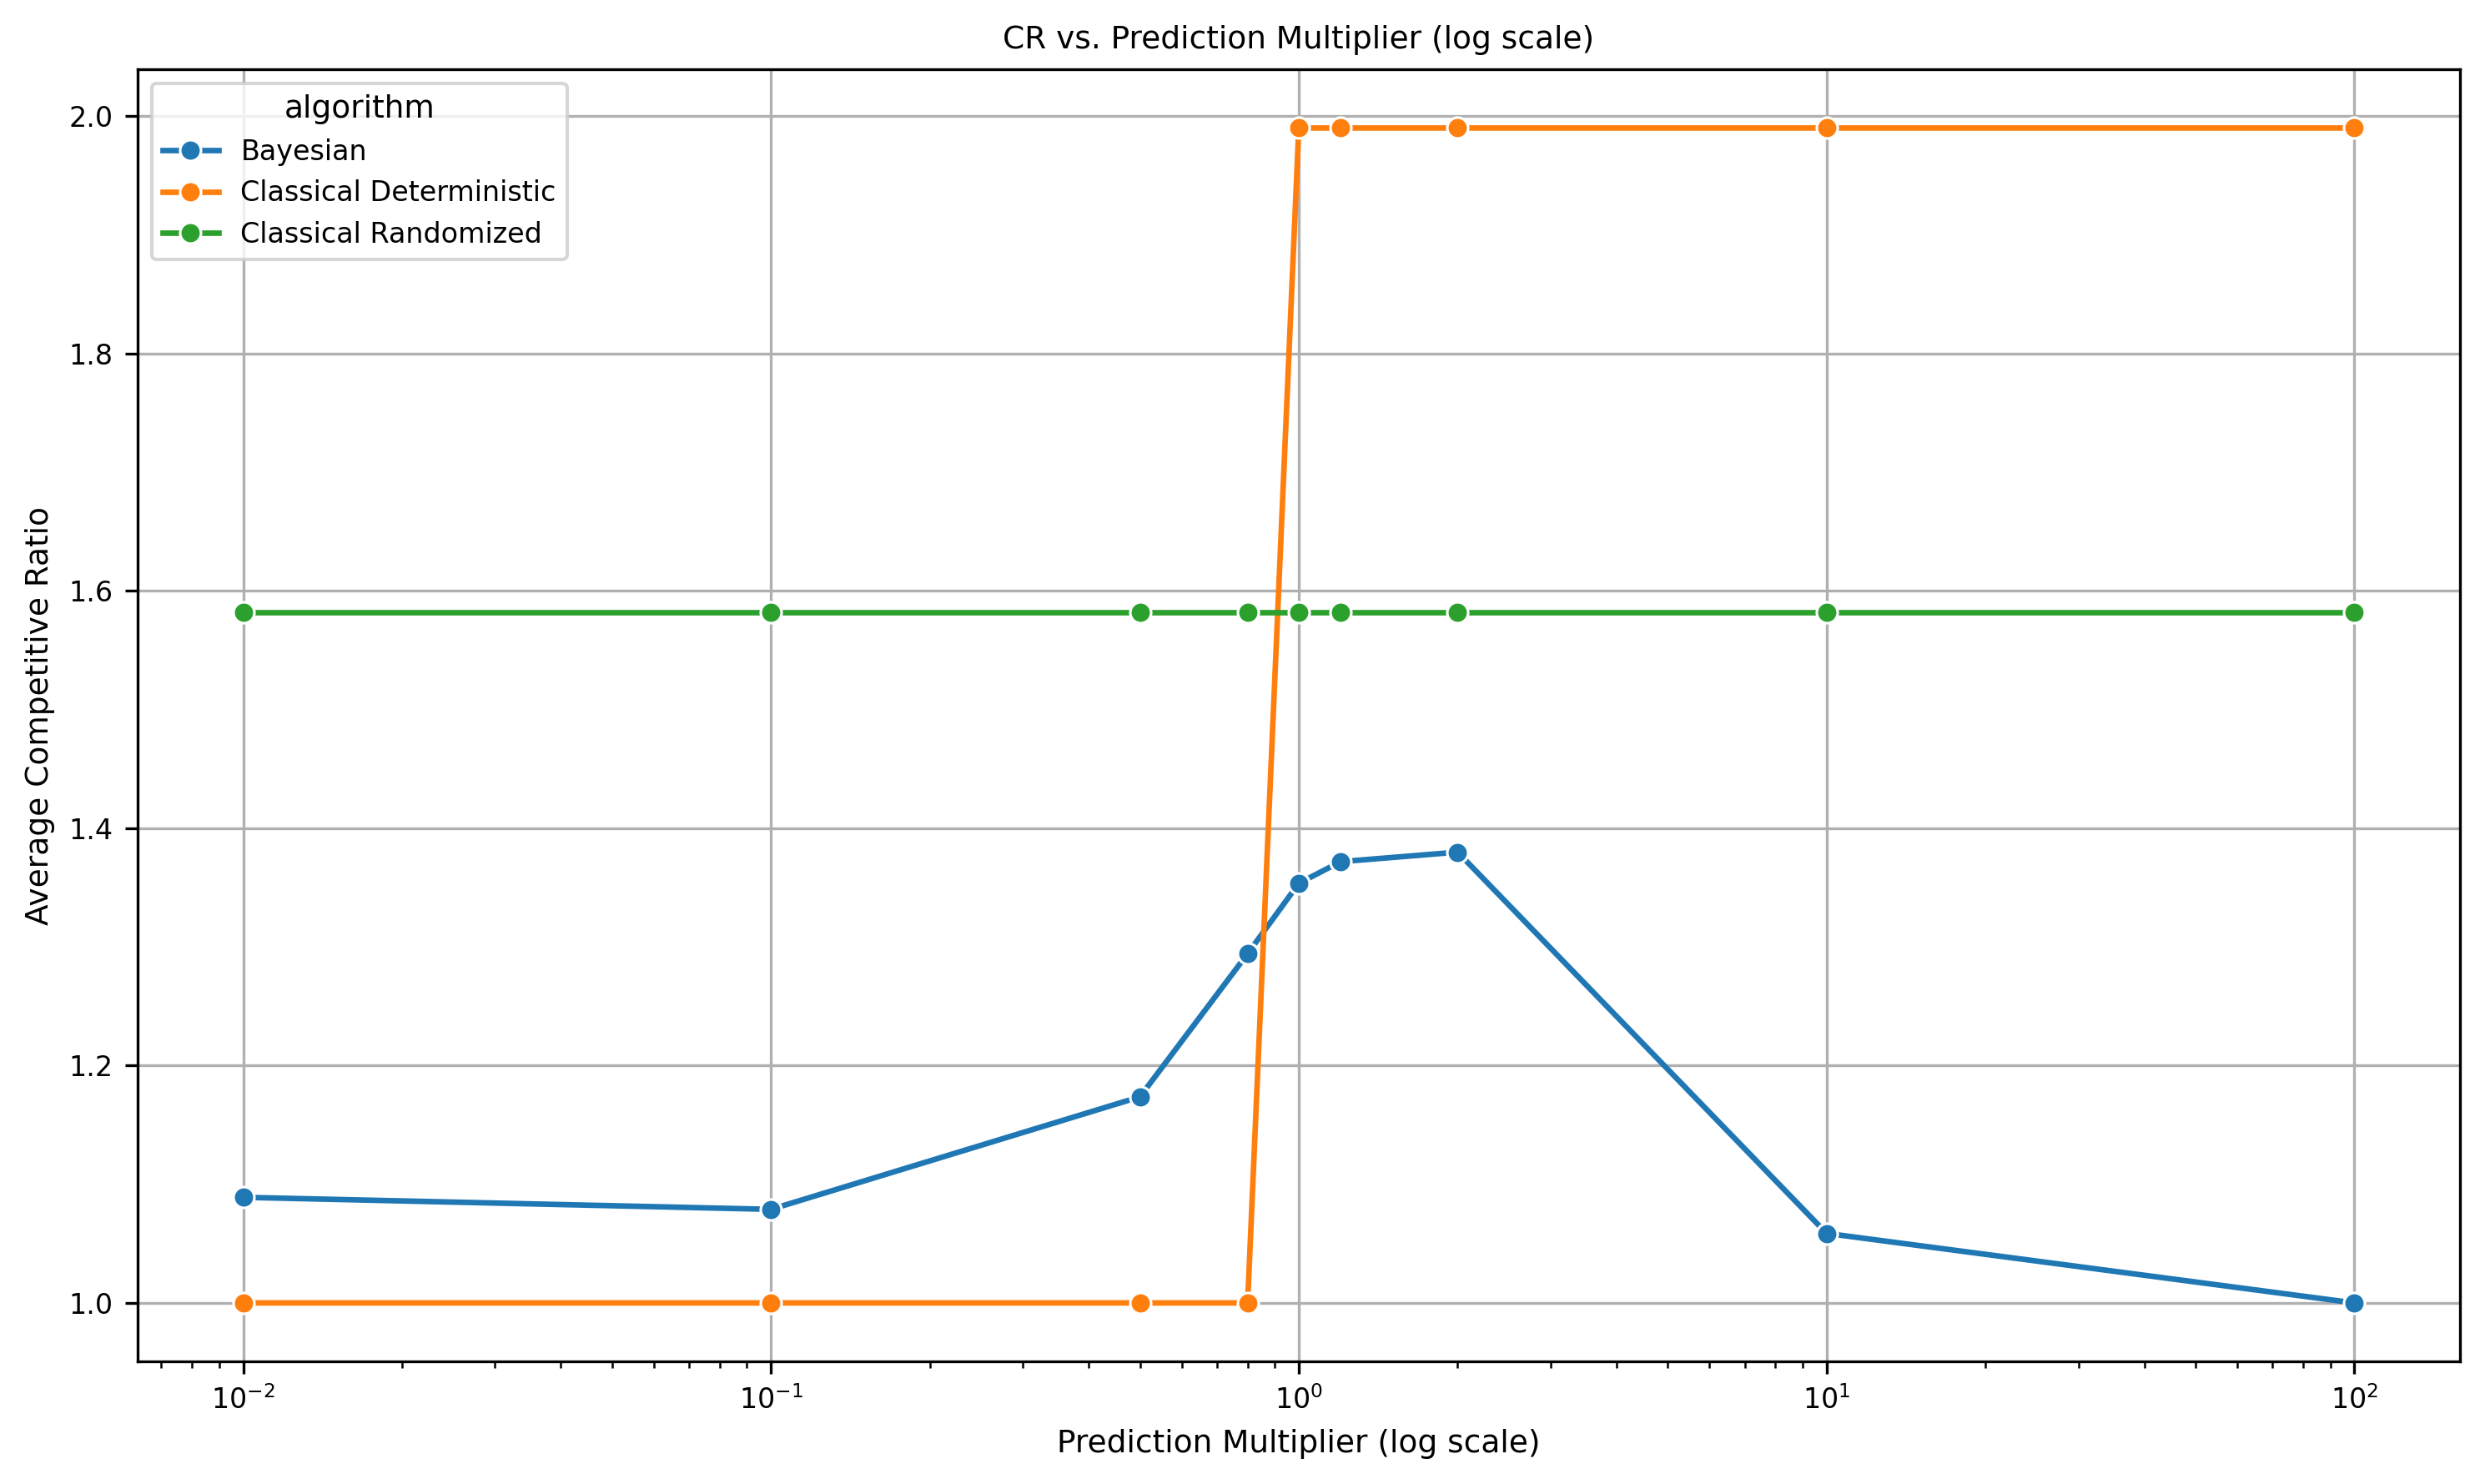

In [5]:
# 실험 파라미터
b = 100
n = 10
lambda_val = 0.5
actual_days = 100
actual_noise = 30
prediction_multipliers = [0.01, 0.1, 0.5, 0.8, 1.0, 1.2, 2.0, 10.0, 100.0]
num_trials = 200

# 알고리즘 목록 (주어진 형식대로)
algorithms = [
    # ("Hybrid", HybridVarianceAwareSkiRentalWithScaling(b=b, n=n, c=1.0)),
    # ("Gaussian", GaussianNoiseSkiRental(b=b, n=n, lambda_val=lambda_val)),
    # ("HeavyTailed", HeavyTailedNoiseSkiRental(b=b, n=n, lambda_val=lambda_val)),
    # ("Adversarial", AdversarialNoiseSkiRental(b=b, n=n, lambda_val=lambda_val)),
    # ("VarianceAware", VarianceAwareSkiRental(b=b, n=n)),
    # ("ExpectedCost", ExpectedCostSkiRental(b=b, n=n)),
    # ("SoftThreshold", SoftThresholdGaussianSkiRental(b=b, n=n)),
    ("Bayesian", BayesianSkiRental(b=b, n=n)),
    # ("LinearDecay", LinearDecaySkiRental(b=b, n=n)),
    # ("PowerLawDecay", PowerLawDecaySkiRental(b=b, n=n)),
    # ("MultiGaussian", MultiGaussianAdaptedSkiRental(b=b, n=n)),
    ("Classical Deterministic", None),
    ("Classical Randomized", None),
]

# 결과 저장
records = []
pbar = tqdm(total=len(algorithms) * len(prediction_multipliers) * num_trials, desc="Running sweep")

for algo_name, algo in algorithms:
    for multiplier in prediction_multipliers:
        for _ in range(num_trials):
            y_pred = actual_days * multiplier
            observations = [y_pred + np.random.normal(0, actual_noise) for _ in range(n)]

            try:
                if algo_name == "Classical Deterministic":
                    cr = classical_deterministic(b, y_pred)

                elif algo_name == "Classical Randomized":
                    cr = classical_randomized(b, y_pred)

                else:
                    decision_day = algo.decide(observations, force_lambda=lambda_val)
                    cr = algo.competitive_ratio(decision_day, actual_days)

                records.append({
                    "algorithm": algo_name,
                    "prediction_multiplier": multiplier,
                    "cr": cr
                })

            except Exception as e:
                print(f"[ERROR] {algo_name}: {type(e).__name__} - {e}")

            pbar.update(1)

pbar.close()
df = pd.DataFrame(records)

# 평균 CR 계산
avg_cr = df.groupby(["algorithm", "prediction_multiplier"])["cr"].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cr, x="prediction_multiplier", y="cr", hue="algorithm", marker="o")
plt.xscale("log")
plt.xlabel("Prediction Multiplier (log scale)")
plt.ylabel("Average Competitive Ratio")
plt.title("CR vs. Prediction Multiplier (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

Running sweep: 100%|██████████| 5400/5400 [00:08<00:00, 644.93it/s]
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy 

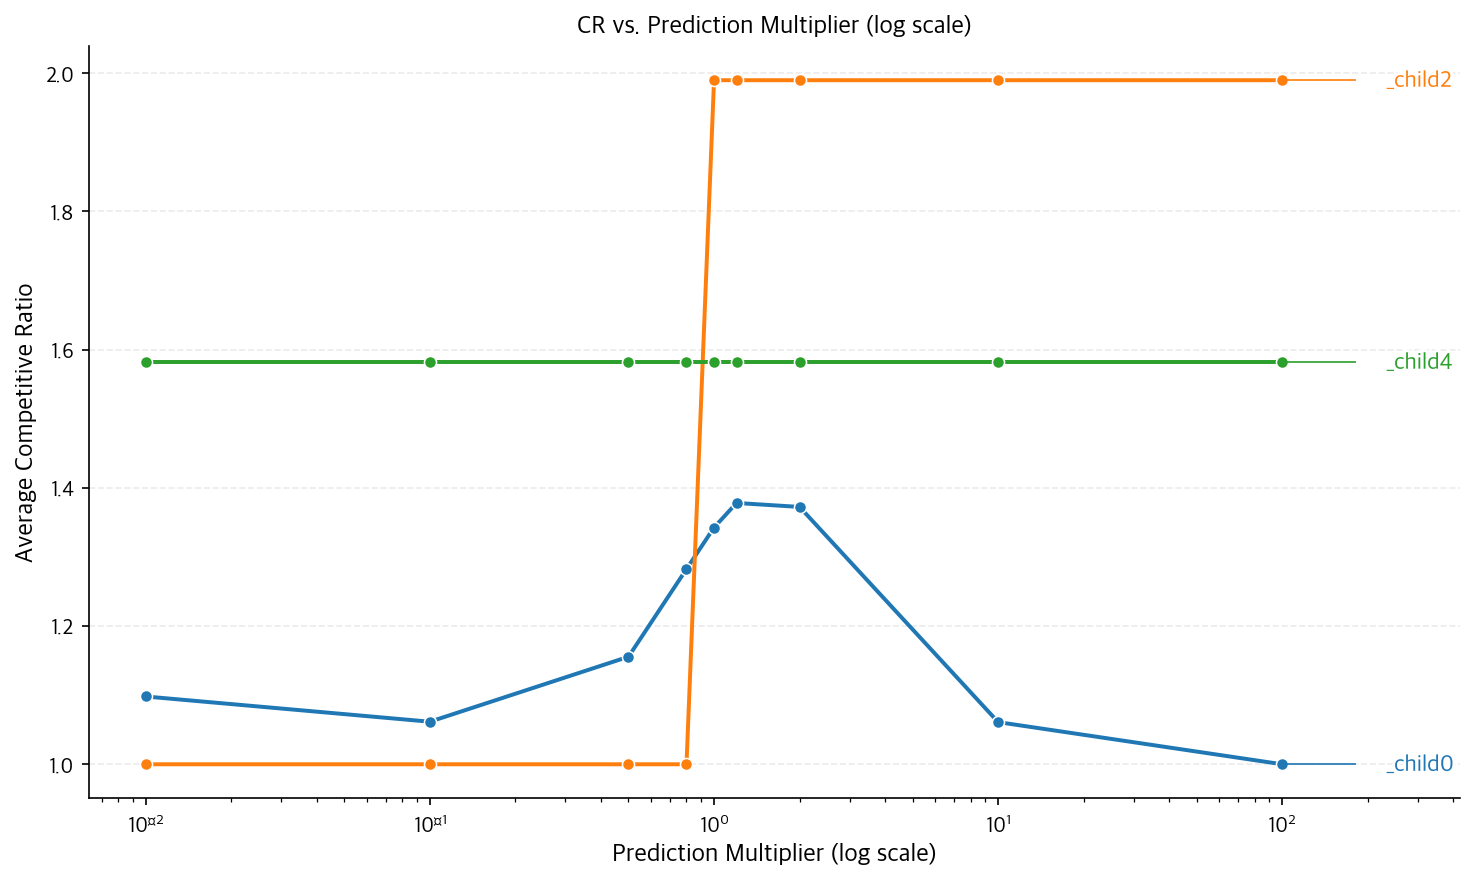

Saved: figs-bosun/exp_cr_vs_multiplier_endlabels.png


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


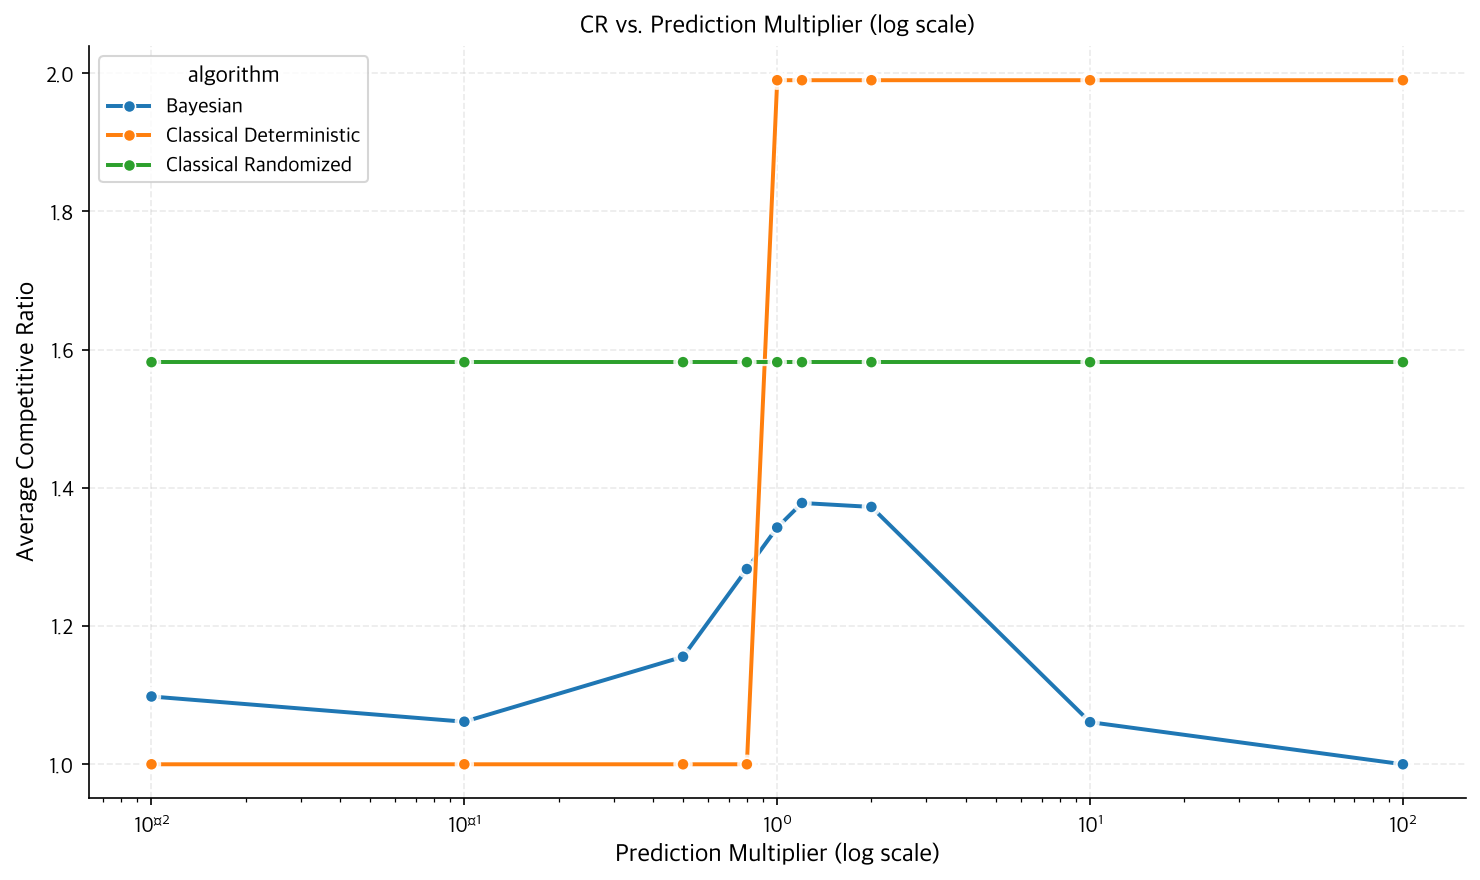

In [18]:
import matplotlib as mpl
from matplotlib import font_manager as fm

# 폰트 지정 (시스템에 설치된 한글 폰트 중 하나 선택)
mpl.rcParams['font.family'] = 'Apple SD Gothic Neo'   # macOS
# mpl.rcParams['font.family'] = 'Malgun Gothic'       # Windows
# mpl.rcParams['font.family'] = 'Noto Sans CJK KR'    # Linux/Google Fonts

# 마이너스 부호도 폰트 내에서 처리하도록 허용
mpl.rcParams['axes.unicode_minus'] = True


plt.figure(figsize=(10, 6))
ax = plt.gca()

sns.lineplot(
    data=avg_cr,
    x="prediction_multiplier",
    y="cr",
    hue="algorithm",
    marker="o",
    ax=ax
)

ax.set_xscale("log")
ax.set_xlabel("Prediction Multiplier (log scale)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs. Prediction Multiplier (log scale)")
ax.grid(True, which="major", axis="both", alpha=0.25, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ---- shadow 효과 ----
stroke = [pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]

for text in [ax.title, ax.xaxis.label, ax.yaxis.label]:
    text.set_path_effects(stroke)

leg = ax.get_legend()
if leg:
    if leg.get_title():
        leg.get_title().set_path_effects(stroke)
    for txt in leg.get_texts():
        txt.set_path_effects(stroke)

for line in ax.lines:
    lw = line.get_linewidth()
    line.set_path_effects([
        pe.Stroke(linewidth=lw + 1.6, foreground="white", alpha=0.85),
        pe.Normal()
    ])

plt.tight_layout()
plt.show()


In [ ]:
# =========================================================
# Experiment 3 (FINAL FIX): Prior Misspecification — Interior Thresholds
#  - FIX: Use b <= E[T - t + 1 | T >= t]   (no min-cap)
#  - Auto-pick b so that t* is interior
#  - Produce 3 focused plots
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

RNG = np.random.default_rng(20251112)

# -----------------------
# Priors
# -----------------------
def gaussian_prior(M: int, mean: float, std: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    p = stats.norm.pdf(x, mean, std)
    s = p.sum()
    return p / s if s > 0 else np.ones(M) / M

def uniform_prior(M: int) -> np.ndarray:
    return np.ones(M, dtype=float) / M

# -----------------------
# Correct threshold rule (NO CAP!)
#   Buy at the first t s.t. b <= E[T - t + 1 | T >= t]
# -----------------------

def compute_buy_threshold_tstar(b: int, prior: np.ndarray) -> int:
    """
    Correct Bayesian threshold (no cap). Returns first t s.t. E[T - t + 1 | T >= t] <= b.
    """
    M = prior.size
    P = np.concatenate([[0.0], np.cumsum(prior)])
    W = np.concatenate([[0.0], np.cumsum(prior * np.arange(1, M + 1))])

    for t in range(1, M + 1):
        S_t = P[M] - P[t - 1]
        if S_t <= 0:
            break
        sum_kp = W[M] - W[t - 1]
        sum_p  = P[M] - P[t - 1]
        E_rem  = (sum_kp - (t - 1) * sum_p) / S_t
        #  조건 방향 반대로: 기대 잔여일이 b보다 작거나 같아지면 산다.
        if E_rem <= b:
            return t
    return M + 1


def tv_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return 0.5 * np.abs(p1 - p2).sum()

# -----------------------
# Pick b so that t* lies inside (target ratio)
# -----------------------
def pick_b_for_interior_tstar(M: int, mean: float, std: float,
                              target_range=(0.3, 0.7)):
    """
    Scan b in [1, M] and pick one with t*/(M+1) in target_range.
    """
    prior = gaussian_prior(M, mean, std)
    candidates = []
    for b in range(1, M + 1):
        tstar = compute_buy_threshold_tstar(b, prior)
        ratio = tstar / (M + 1)
        candidates.append((b, tstar, ratio))

    lo, hi = target_range
    in_range = [c for c in candidates if lo <= c[2] <= hi]
    if in_range:
        # 중앙에 가까운 b 선택
        in_range.sort(key=lambda x: abs(x[2] - 0.5*(lo+hi)))
        return in_range[0][0], in_range[0][1]

    # 내부에 없으면 가장 가까운 b 선택
    candidates.sort(key=lambda x: abs(x[2] - 0.5*(lo+hi)))
    b, t, r = candidates[0]
    if r <= 0.05 or r >= 0.95:
        print(f"⚠️ Warning: could not find interior t* for M={M}. Using fallback b≈{mean/3:.1f}")
        b = int(round(mean/3))
        t = compute_buy_threshold_tstar(b, prior)
    return b, t


# -----------------------
# Core experiment
# -----------------------
def run_experiment(n_trials=10000):
    configs = [
        ("High Uncertainty (σ/μ≈0.42)",   500, 120.0, 50.0),
        ("Medium Uncertainty (σ/μ≈0.33)", 300,  90.0, 30.0),
        ("Low Uncertainty (σ/μ≈0.31)",    200,  65.0, 20.0),
    ]

    rows = []

    print("\n" + "="*74)
    print("EXPERIMENT 3 (FIXED RULE): PRIOR MISSPECIFICATION — INTERIOR THRESHOLDS")
    print("="*74)

    for name, M, mu, sigma in configs:
        true_prior = gaussian_prior(M, mu, sigma)

        # b 선택: t*/(M+1) ~ [0.30, 0.70]
        b, t_probe = pick_b_for_interior_tstar(M, mu, sigma, target_range=(0.30, 0.70))

        # 최적(=true prior 기준) 임계치
        t_star_opt = compute_buy_threshold_tstar(b, true_prior)

        # 샘플 고정
        days = np.arange(1, M + 1)
        T_samples = RNG.choice(days, size=n_trials, p=true_prior)

        # baseline cost / CR
        cost_opt  = np.where(T_samples < t_star_opt, T_samples, (t_star_opt - 1) + b).astype(float)
        opt_cost  = np.minimum(T_samples, b).astype(float)
        cr_base   = cost_opt / opt_cost
        base_cost = float(cost_opt.mean())
        base_cr   = float(cr_base.mean())

        print(f"\n{name}")
        print(f"  Params: M={M}, b={b}, E[T]={mu:.1f}, σ={sigma:.1f}")
        print(f"  Baseline t* = {t_star_opt} (probe={t_probe}), Baseline CR = {base_cr:.4f}, Cost = {base_cost:.3f}")

        # 시나리오
        scenarios = []
        # Mean Error
        for shift in [-0.5, -0.3, -0.1, +0.1, +0.3, +0.5]:
            m_mu = float(np.clip(mu * (1 + shift), 2.0, M - 2.0))
            scenarios.append(("Mean Error", shift, gaussian_prior(M, m_mu, sigma)))
        # Variance Error
        for vf in [0.3, 0.5, 0.7, 1.5, 2.5, 4.0]:
            scenarios.append(("Variance Error", vf, gaussian_prior(M, mu, sigma * vf)))
        # Poor Model (mix with uniform)
        U = uniform_prior(M)
        for delta in [0.2, 0.4, 0.6, 0.8]:
            mix = (1 - delta) * true_prior + delta * U
            mix /= mix.sum()
            scenarios.append(("Poor Model", delta, mix))

        for s_type, param, miss_prior in scenarios:
            tv = tv_distance(true_prior, miss_prior)
            t_star = compute_buy_threshold_tstar(b, miss_prior)

            cost = np.where(T_samples < t_star, T_samples, (t_star - 1) + b).astype(float)
            cr   = cost / opt_cost

            avg_cost = float(cost.mean())
            regret   = avg_cost - base_cost
            pct_inc  = 100.0 * regret / base_cost if base_cost > 0 else 0.0

            rows.append({
                "config": name, "M": M, "b": b,
                "scenario_type": s_type, "parameter": param,
                "tv_distance": float(tv),
                "mean_cr": float(cr.mean()),
                "std_cr": float(cr.std(ddof=1)),
                "p95_cr": float(np.percentile(cr, 95)),
                "p99_cr": float(np.percentile(cr, 99)),
                "failure_rate": float(np.mean(cr > 1.5)),
                "severe_fail": float(np.mean(cr > 2.0)),
                "t_star": int(t_star),
                "t_star_optimal": int(t_star_opt),
                "threshold_error": int(t_star - t_star_opt),
                "avg_cost": avg_cost,
                "baseline_cost": base_cost,
                "regret": float(regret),
                "pct_cost_increase": float(pct_inc),
            })

    return pd.DataFrame(rows)

# -----------------------
# Focused 3 plots
# -----------------------
def plot_focused_three(df: pd.DataFrame,
                       tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
                       use_violin=True, add_heatmap=True):
    mpl.rcParams.update({
        "font.size": 10,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "legend.fontsize": 9,
    })

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axA, axB, axC, axD = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

    # (a) Performance degradation
    ax = axA
    regimes = df["config"].unique().tolist()
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"][:len(regimes)]
    for c, reg in zip(colors, regimes):
        d = df[df["config"] == reg].sort_values("tv_distance")
        ax.plot(d["tv_distance"], d["pct_cost_increase"],
                marker="o", linestyle="-", linewidth=2, ms=4, color=c, label=reg.split(" (")[0])
    ax.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    ax.set_title("(a) Performance Degradation")
    ax.set_xlabel("Total Variation Distance")
    ax.set_ylabel("Cost Increase (%)")
    ax.grid(axis='y', alpha=0.3, linestyle="--")
    ax.legend(frameon=True)

    # (d) Impact by Misspecification Type
    ax = axB
    types = ["Mean Error", "Variance Error", "Poor Model"]
    tcolors = ["#d62728", "#9467bd", "#8c564b"]
    for c, t in zip(tcolors, types):
        d = df[df["scenario_type"] == t].sort_values("tv_distance")
        ax.plot(d["tv_distance"], d["pct_cost_increase"],
                marker="o", linestyle="-", linewidth=2, ms=4, color=c, label=t)
    ax.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    ax.set_title("(d) Impact by Misspecification Type")
    ax.set_xlabel("Total Variation Distance")
    ax.set_ylabel("Cost Increase (%)")
    ax.grid(axis='y', alpha=0.3, linestyle="--")
    ax.legend(frameon=True)

    # (new) CR Distribution by TV bins  (use mean_cr per row as proxy)
    ax = axC
    bins = pd.IntervalIndex.from_breaks(tv_edges)
    df2 = df.copy()
    df2["tv_bin"] = pd.cut(df2["tv_distance"], bins=bins, include_lowest=True)
    cat = df2["tv_bin"].cat.categories
    labels = [str(iv) for iv in cat]
    series = [df2.loc[df2["tv_bin"] == iv, "mean_cr"].dropna().values for iv in cat]

    pos = np.arange(1, len(labels) + 1)
    if use_violin:
        nonempty = [(p, s) for p, s in zip(pos, series) if s.size > 0]
        if nonempty:
            ppos, pser = zip(*nonempty)
            parts = ax.violinplot(pser, positions=ppos, widths=0.8,
                                  showmeans=False, showmedians=True, showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor("#5DA5DA"); pc.set_alpha(0.6)
            if "cmedians" in parts:
                parts["cmedians"].set_linewidth(2.0)
    else:
        ax.boxplot([s if s.size > 0 else np.array([np.nan]) for s in series],
                   positions=pos, widths=0.8, showfliers=False)

    ax.set_title("(new) CR Distribution by TV Distance")
    ax.set_xlabel("TV Distance Bins")
    ax.set_ylabel("Competitive Ratio")
    ax.set_xticks(pos); ax.set_xticklabels(labels)
    ax.grid(axis='y', alpha=0.3, linestyle="--")

    # (opt) Heatmap: Avg cost increase by (tv_bin, type)
    ax = axD
    ax.set_title("(opt) Avg Cost Increase by TV bin × Type")
    piv = (df2.groupby(["tv_bin", "scenario_type"])["pct_cost_increase"]
             .mean()
             .unstack("scenario_type")
             .reindex(index=cat, columns=types))
    mat = piv.fillna(0.0).values
    im = ax.imshow(mat, aspect="auto", cmap="viridis", origin="upper")
    ax.set_yticks(np.arange(len(cat))); ax.set_yticklabels([str(iv) for iv in cat])
    ax.set_xticks(np.arange(len(types))); ax.set_xticklabels(types, rotation=25, ha="right")
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            ax.text(j, i, f"{val:.1f}%", va="center", ha="center",
                    color="white" if val > mat.max()*0.6 else "black", fontsize=9)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Avg Cost Increase (%)")

    plt.suptitle("Robustness under Correct Rule: Focused Views", fontsize=14, fontweight="bold", y=0.995)
    fig.tight_layout(rect=[0, 0.0, 1, 0.97])
    return fig

# -----------------------
# Run & Save
# -----------------------
if __name__ == "__main__":
    mpl.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 600,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

    os.makedirs("figs-bosun", exist_ok=True)

    df = run_experiment(n_trials=10000)
    df_path = "figs-bosun/exp3.csv"
    df.to_csv(df_path, index=False)

    fig = plot_focused_three(df, tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
                             use_violin=True, add_heatmap=True)
    fig.savefig("figs-bosun/exp3final.png", bbox_inches="tight")

    print("\nSaved:")
    print(" -", df_path)
    # print(" - figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.pdf")
    print(" - figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.png")


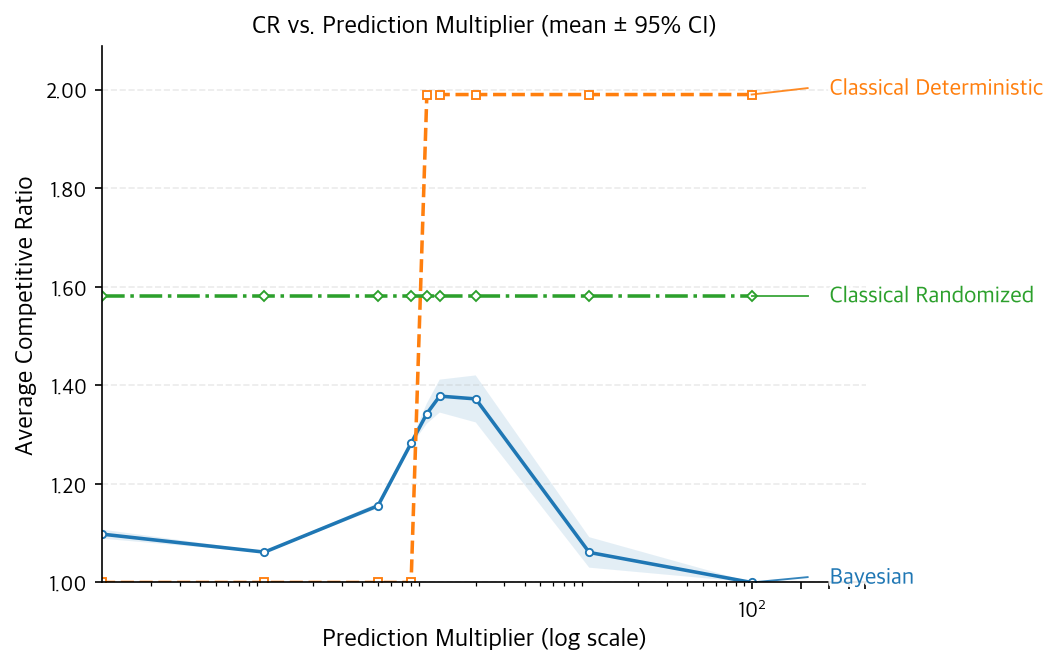

Saved: figs-bosun/exp_cr_vs_multiplier_endlabels.pdf
Saved: figs-bosun/exp2_fffinal.png


In [21]:

# ======= End-label + Shadow 스타일 플롯 (prediction_multiplier vs cr) =======
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# 1) 집계: mean ± 95% CI
agg = (
    df.groupby(["algorithm", "prediction_multiplier"])["cr"]
      .agg(mean="mean", sem="sem", count="count")
      .reset_index()
)
agg["ci95"]   = 1.96 * agg["sem"].fillna(0)
agg["ci_low"] = agg["mean"] - agg["ci95"]
agg["ci_high"] = agg["mean"] + agg["ci95"]

# 2) 스타일 준비
order      = agg["algorithm"].drop_duplicates().tolist()
palette    = list(plt.cm.tab10.colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "P", "X", "*"]

# 3) 플로팅
fig, ax = plt.subplots(figsize=(7.2, 4.6))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo].sort_values("prediction_multiplier")
    if tmp.empty:
        continue

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 신뢰구간 음영
    ax.fill_between(
        tmp["prediction_multiplier"].values, tmp["ci_low"].values, tmp["ci_high"].values,
        alpha=0.12, facecolor=color, edgecolor="none"
    )

    # 평균 라인 + 마커
    ax.plot(
        tmp["prediction_multiplier"].values, tmp["mean"].values,
        linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
        markerfacecolor="white", markeredgewidth=0.9,
        color=color
    )

    # 마지막 점 저장(라벨용)
    x_last = float(tmp["prediction_multiplier"].values[-1])
    y_last = float(tmp["mean"].values[-1])
    end_points.append((algo, x_last, y_last, color))

# 4) 축/범위
ax.set_xscale("log")
ax.set_xlabel("Prediction Multiplier (log scale)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs. Prediction Multiplier (mean ± 95% CI)")

x_min, x_max = float(agg["prediction_multiplier"].min()), float(agg["prediction_multiplier"].max())
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)  # 라벨 그린 후 오른쪽 여백 조정

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# 5) 선 끝 라벨링 (충돌 방지 + shadow 외곽선)
end_points.sort(key=lambda t: t[2])  # y값 기준 정렬
yrange = y_max - y_min

# 오른쪽 텍스트 x-padding (로그축 고려한 상대 padding)
xpad = 0.12 * (np.log10(x_max) - np.log10(x_min))
xpad_lin = 10**(np.log10(x_max) + xpad) - x_max
xpad_lin = max(xpad_lin, (x_max - x_min) * 0.08)

min_sep = 0.035 * yrange
base_dy = 0.012 * yrange

N = len(end_points)
lin_offsets = np.linspace(-base_dy, base_dy, num=N)
desired_y = {ep[0]: float(np.clip(ep[2] + off, y_min + 0.01*yrange, y_max - 0.01*yrange))
             for off, ep in zip(lin_offsets, end_points)}

# (옵션) 그룹별 미세 오프셋이 필요하면 여기에 dict 추가 가능
# group_nudge = {"Classical Deterministic": +0.018*yrange, ...}
# for algo, _, _, _ in end_points:
#     desired_y[algo] = float(np.clip(desired_y[algo] + group_nudge.get(algo, 0.0),
#                                     y_min+0.01*yrange, y_max-0.01*yrange))

# 아래→위, 위→아래 스윕으로 min_sep 확보
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

pos_map = dict(placed)

# 연결선 + 텍스트 (shadow 외곽선)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map[algo]

    # 연결선(선 끝 → 라벨)
    ax.plot([x_last, x_last + 0.6*xpad_lin], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)

    # 라벨 텍스트(흰 외곽선)
    ax.text(
        x_last + xpad_lin, y_lab, algo,
        color=color, fontsize=11, va='center', ha='left', fontweight='semibold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
    )

# 라벨 공간 위해 오른쪽 여백 확장
ax.set_xlim(x_min, x_max + xpad_lin * 2.0)

fig.tight_layout(pad=1.2)

# 6) 저장
os.makedirs("figs-bosun", exist_ok=True)
out_pdf = "figs-bosun/exp_cr_vs_multiplier_endlabels.pdf"
out_png = "figs-bosun/exp2_fffinal.png"
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, bbox_inches="tight", dpi=600)
plt.show()

print(f"Saved: {out_pdf}\nSaved: {out_png}")

In [ ]:

# ======= End-label + Shadow 스타일 플롯 (prediction_multiplier vs cr) =======
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# 1) 집계: mean ± 95% CI
agg = (
    df.groupby(["algorithm", "prediction_multiplier"])["cr"]
      .agg(mean="mean", sem="sem", count="count")
      .reset_index()
)
agg["ci95"]   = 1.96 * agg["sem"].fillna(0)
agg["ci_low"] = agg["mean"] - agg["ci95"]
agg["ci_high"] = agg["mean"] + agg["ci95"]

# 2) 스타일 준비
order      = agg["algorithm"].drop_duplicates().tolist()
palette    = list(plt.cm.tab10.colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "P", "X", "*"]

# 3) 플로팅
fig, ax = plt.subplots(figsize=(7.2, 4.6))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo].sort_values("prediction_multiplier")
    if tmp.empty:
        continue

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 신뢰구간 음영
    ax.fill_between(
        tmp["prediction_multiplier"].values, tmp["ci_low"].values, tmp["ci_high"].values,
        alpha=0.12, facecolor=color, edgecolor="none"
    )

    # 평균 라인 + 마커
    ax.plot(
        tmp["prediction_multiplier"].values, tmp["mean"].values,
        linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
        markerfacecolor="white", markeredgewidth=0.9,
        color=color
    )

    # 마지막 점 저장(라벨용)
    x_last = float(tmp["prediction_multiplier"].values[-1])
    y_last = float(tmp["mean"].values[-1])
    end_points.append((algo, x_last, y_last, color))

# 4) 축/범위
ax.set_xscale("log")
ax.set_xlabel("Prediction Multiplier (log scale)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs. Prediction Multiplier (mean ± 95% CI)")

x_min, x_max = float(agg["prediction_multiplier"].min()), float(agg["prediction_multiplier"].max())
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)  # 라벨 그린 후 오른쪽 여백 조정

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# 5) 선 끝 라벨링 (충돌 방지 + shadow 외곽선)
end_points.sort(key=lambda t: t[2])  # y값 기준 정렬
yrange = y_max - y_min

# 오른쪽 텍스트 x-padding (로그축 고려한 상대 padding)
xpad = 0.12 * (np.log10(x_max) - np.log10(x_min))
xpad_lin = 10**(np.log10(x_max) + xpad) - x_max
xpad_lin = max(xpad_lin, (x_max - x_min) * 0.08)

min_sep = 0.035 * yrange
base_dy = 0.012 * yrange

N = len(end_points)
lin_offsets = np.linspace(-base_dy, base_dy, num=N)
desired_y = {ep[0]: float(np.clip(ep[2] + off, y_min + 0.01*yrange, y_max - 0.01*yrange))
             for off, ep in zip(lin_offsets, end_points)}

# (옵션) 그룹별 미세 오프셋이 필요하면 여기에 dict 추가 가능
# group_nudge = {"Classical Deterministic": +0.018*yrange, ...}
# for algo, _, _, _ in end_points:
#     desired_y[algo] = float(np.clip(desired_y[algo] + group_nudge.get(algo, 0.0),
#                                     y_min+0.01*yrange, y_max-0.01*yrange))

# 아래→위, 위→아래 스윕으로 min_sep 확보
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

pos_map = dict(placed)

# 연결선 + 텍스트 (shadow 외곽선)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map[algo]

    # 연결선(선 끝 → 라벨)
    ax.plot([x_last, x_last + 0.6*xpad_lin], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)

    # 라벨 텍스트(흰 외곽선)
    ax.text(
        x_last + xpad_lin, y_lab, algo,
        color=color, fontsize=11, va='center', ha='left', fontweight='semibold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
    )

# 라벨 공간 위해 오른쪽 여백 확장
ax.set_xlim(x_min, x_max + xpad_lin * 2.0)

fig.tight_layout(pad=1.2)

# 6) 저장
os.makedirs("figs-bosun", exist_ok=True)
out_pdf = "figs-bosun/exp_cr_vs_multiplier_endlabels.pdf"
out_png = "figs-bosun/exp2_fffinal.png"
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, bbox_inches="tight", dpi=600)
plt.show()

print(f"Saved: {out_pdf}\nSaved: {out_png}")

# Experiment 4 Final


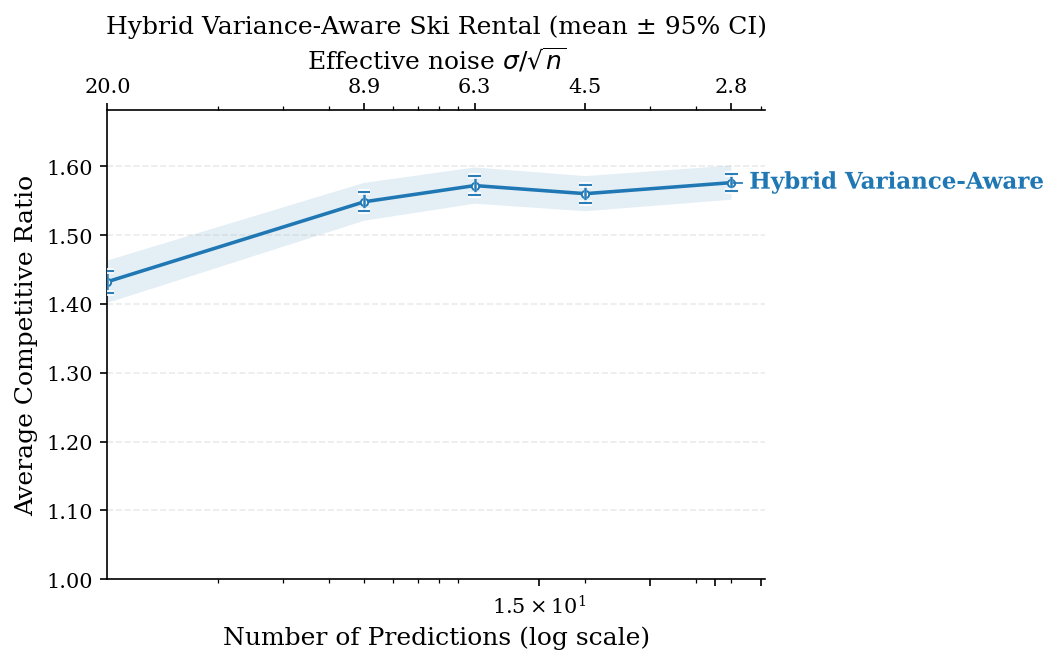

Saved: figs-bosun/exp_hybrid_multi_predictions_endlabels.pdf
Saved: figs-bosun/exp_hybrid_multi_predictions_endlabels.png


In [32]:
# ======= Hybrid Multi-Prediction Paper Plot (논문형 End-label + Shadow 스타일) =======
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ----------------------------
# 1) 데이터 생성 (실험 루프)
# ----------------------------
b_cost = 100
true_horizon = 100
noise_level = 20.0
n_values = [1, 5, 10, 20, 50]
trials = 500
rng = np.random.default_rng(42)

rows = []
for n in n_values:
    algo = HybridVarianceAwareSkiRental(b=b_cost, n=n, gamma=0.5)
    crs = []
    for _ in range(trials):
        d = algo.decide(true_horizon, noise_level)   # ✅ 현재 decide(y_true, actual_noise) 구조에 맞게
        cost_alg = algo.cost(d, true_horizon)
        opt_cost = min(true_horizon, b_cost)
        crs.append(cost_alg / opt_cost)
    crs = np.asarray(crs)
    rows.append({
        "n": n,
        "sigma_eff": noise_level / np.sqrt(n),
        "mean": crs.mean(),
        "sem": crs.std(ddof=1) / np.sqrt(trials)
    })

df_multi = pd.DataFrame(rows)
df_multi["ci95"] = 1.96 * df_multi["sem"]
df_multi["ci_low"] = df_multi["mean"] - df_multi["ci95"]
df_multi["ci_high"] = df_multi["mean"] + df_multi["ci95"]

# ----------------------------
# 2) 스타일 설정
# ----------------------------
palette    = list(plt.cm.tab10.colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "P", "X", "*"]

fig, ax = plt.subplots(figsize=(7.2, 4.6))
color = palette[0]   # 단일 알고리즘 실험 → 첫 색상만 사용

# ----------------------------
# 3) 플롯 (같은 포맷)
# ----------------------------
x = df_multi["n"].values
y = df_multi["mean"].values
ci_low, ci_high = df_multi["ci_low"].values, df_multi["ci_high"].values

# 신뢰구간 음영
ax.fill_between(x, ci_low, ci_high, alpha=0.12, facecolor=color, edgecolor="none")

# 평균 라인 + 마커
ax.plot(
    x, y,
    linewidth=1.7, linestyle="-", marker="o", markersize=3.5,
    markerfacecolor="white", markeredgewidth=0.9, color=color,
    label="Hybrid Variance-Aware"
)

# --- 세로 에러바: 표준오차(SE) 시각화 ---
y_se = df_multi["sem"].values  # 이미 위에서 계산해둔 표준오차
err = ax.errorbar(
    x, y, yerr=y_se,
    fmt="none",                # 점/선은 추가로 그리지 않음 (우린 위에서 이미 라인/마커 그림)
    ecolor=color,
    elinewidth=1.2,
    capsize=3,
    alpha=0.95,
    zorder=4
)

# 에러바에도 흰 외곽선(shadow) 적용 → 인쇄 대비 강화
import matplotlib.patheffects as pe
for cap in err[1]:  # caps
    cap.set_path_effects([pe.Stroke(linewidth=cap.get_linewidth()+1.0, foreground="white", alpha=0.9), pe.Normal()])
for bar in err[2]:  # vertical bars
    bar.set_path_effects([pe.withStroke(linewidth=1.2, foreground="white", alpha=0.9)])


# ----------------------------
# 4) 축/범위 설정
# ----------------------------
ax.set_xscale("log")
ax.set_xlabel("Number of Predictions (log scale)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("Hybrid Variance-Aware Ski Rental (mean ± 95% CI)")

x_min, x_max = float(df_multi["n"].min()), float(df_multi["n"].max())
y_min, y_max = 1.0, float(df_multi["ci_high"].max()) * 1.05
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ----------------------------
# 5) 상단 보조축 (σ/√n)
# ----------------------------
ax_top = ax.secondary_xaxis("top", functions=(lambda n: n, lambda n: n))
sigma_eff = df_multi["sigma_eff"].values
ax_top.set_xticks(x)
ax_top.set_xticklabels([f"{v:.1f}" if v >= 1 else f"{v:.2f}" for v in sigma_eff])
ax_top.set_xlabel(r"Effective noise $\sigma / \sqrt{n}$")

# ----------------------------
# 6) 선 끝 Shadow 라벨
# ----------------------------
x_last, y_last = x[-1], y[-1]
xpad = (x_max - x_min) * 0.12
ax.text(
    x_last + xpad, y_last, "Hybrid Variance-Aware",
    color=color, fontsize=11, va='center', ha='left', fontweight='semibold',
    path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
)
ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_last],
        color=color, linewidth=0.9, alpha=0.9)

# ----------------------------
# 7) 저장/출력
# ----------------------------
ax.set_xlim(x_min, x_max + xpad * 2)
fig.tight_layout(pad=1.2)
os.makedirs("figs-bosun", exist_ok=True)
out_pdf = "figs-bosun/exp_hybrid_multi_predictions_endlabels.pdf"
out_png = "figs-bosun/exp_hybrid_multi_predictions_endlabels.png"
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, bbox_inches="tight", dpi=600)
plt.show()

print(f"Saved: {out_pdf}\nSaved: {out_png}")


# Experiment 5 

[t*] Bi-modal: 81, Tri-modal: 81, Seasonal: 81  (with b=25, M=80)


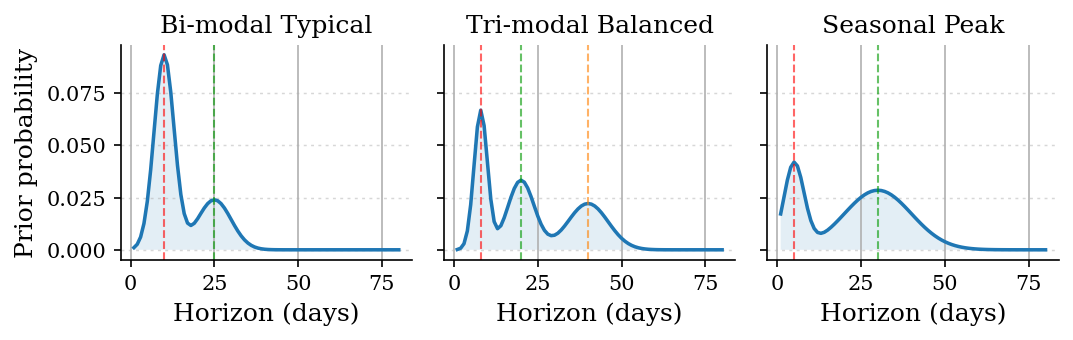

Saved: figs-bosun/multimodal_priors_tstar.png


In [33]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm

# ---------------------------
# 기본 스타일(논문형)
# ---------------------------
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 1.8,
    "savefig.dpi": 600,
    "figure.dpi": 150,
})

os.makedirs("figs-bosun", exist_ok=True)

# ---------------------------
# 유틸: prior 생성 & 정규화
# ---------------------------
def discretize_gaussian_mixture(M, components):
    """
    components: list of (weight, mu, sigma)
    returns prior over k=1..M (np.array length M)
    """
    x = np.arange(1, M+1)
    p = np.zeros_like(x, dtype=float)
    for w, mu, sigma in components:
        p += w * norm.pdf(x, loc=mu, scale=sigma)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

def discretize_trimodal(M, modes, stds, weights):
    x = np.arange(1, M+1)
    p = np.zeros(M, dtype=float)
    for w, m, s in zip(weights, modes, stds):
        p += w * norm.pdf(x, loc=m, scale=s)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

# ---------------------------
# t* 계산 (Bayesian 잔여렌탈 기대비용 규칙)
# ---------------------------
def optimal_t_star(b, M, prior):
    """
    prior[k-1] = P(K=k)
    buy at first t with b <= E[min{K-t+1,b} | K>=t]
    if never, return M+1 (never buy)
    """
    prior = np.asarray(prior, dtype=float)
    prior /= prior.sum()
    # 누적 생존확률 Z_t = P[K>=t]
    Z = np.flip(np.cumsum(np.flip(prior)))  # Z[t-1] = sum_{k=t..M} prior[k-1]
    for t in range(1, M+1):
        if Z[t-1] <= 0:
            continue
        # posterior on {K>=t}: p_{t,k} = prior[k-1]/Z_t for k>=t
        # E_rent(t) = sum_{k=t..M} p_{t,k} * min{k - t + 1, b}
        ks = np.arange(t, M+1)
        post = prior[ks-1] / Z[t-1]
        rent_costs = np.minimum(ks - t + 1, b)
        E_rent = np.sum(post * rent_costs)
        if b <= E_rent:
            return t
    return M + 1  # never buy

# ---------------------------
# 케이스 정의 (논문 서술과 동일)
# ---------------------------
M = 80   # 그림 가독성을 위해 축소. 논문표현 맞추려면 60~120 권장
# !!! 텍스트의 t*를 재현하려면 b를 조정하세요 !!!
b = 25   # 예: 25 정도로 두면 10/25/30 같은 모드에서 직관적인 t*가 나옴

# (1) Bi-modal Typical: 0.7*N(10,3^2) + 0.3*N(25,5^2)
prior_bi = discretize_gaussian_mixture(
    M, components=[(0.7, 10, 3), (0.3, 25, 5)]
)

# (2) Tri-modal Balanced: equal weights at 8, 20, 40
prior_tri = discretize_trimodal(
    M, modes=[8, 20, 40], stds=[2, 4, 6], weights=[1/3, 1/3, 1/3]
)

# (3) Seasonal Peak: 0.3*N(5,3^2) + 0.7*N(30,10^2)
prior_season = discretize_gaussian_mixture(
    M, components=[(0.3, 5, 3), (0.7, 30, 10)]
)

# t* 계산
t_bi  = optimal_t_star(b, M, prior_bi)
t_tri = optimal_t_star(b, M, prior_tri)
t_sea = optimal_t_star(b, M, prior_season)

print(f"[t*] Bi-modal: {t_bi}, Tri-modal: {t_tri}, Seasonal: {t_sea}  (with b={b}, M={M})")

# ---------------------------
# 그림: 3-패널 (논문 형식)
# ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(7.2, 2.4), sharey=True)

cases = [
    ("Bi-modal Typical", prior_bi, [10, 25], [(1.0, 0, 0), (0, 0.6, 0)], t_bi),
    ("Tri-modal Balanced", prior_tri, [8, 20, 40], [(1.0, 0, 0), (0, 0.6, 0), (1.0, 0.5, 0)], t_tri),
    ("Seasonal Peak", prior_season, [5, 30], [(1.0, 0, 0), (0, 0.6, 0)], t_sea),
]

x = np.arange(1, M+1)
shadow = [pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]

for ax, (title, prior, modes, mode_colors, t_star) in zip(axes, cases):
    # prior 곡선 + 리본
    ax.plot(x, prior, color="tab:blue", linewidth=1.7)
    ax.fill_between(x, 0, prior, color="tab:blue", alpha=0.12, edgecolor="none")

    # 모드 표시(점선)
    for m, c in zip(modes, mode_colors):
        ax.axvline(m, color=c, linestyle="--", linewidth=1.0, alpha=0.6)

    # t* 표시(굵은 점선 + 라벨 shadow)
    if t_star <= M:
        ax.axvline(t_star, color="tab:orange", linestyle="--", linewidth=2.0, alpha=0.9)
        ax.text(t_star+0.5, max(prior)*0.9, r"$t^\*$",
                color="tab:orange", fontsize=11, va="top", ha="left",
                path_effects=shadow)

    # 축/레이블
    ax.set_title(title)
    ax.set_xlabel("Horizon (days)")
    ax.grid(True, axis="y", linestyle=(0, (2, 3)), linewidth=0.7, alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Prior probability")
fig.tight_layout()
out_png = "figs-bosun/multimodal_priors_tstar.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")


# 여기서부터 진짜

## experiment 1

In [ ]:
# -------------------------------------------------
# (6) 플로팅: 선 끝 라벨링(legend 제거, PNG만 저장)
# -------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ===== 샘플 데이터 (agg 미정의 시 생성) =====
if 'agg' not in globals():
    np.random.seed(0)
    sample_algos = [
        "Classical Deterministic",
        "Classical Randomized",
        "Prediction-based (δ=1.0×σ)",
        "Prediction-based (δ=0.5×σ)",
        "Bayesian (ours)"
    ]
    noise_levels = np.arange(0, 60, 10)
    rows = []
    for algo in sample_algos:
        mean = 1.0 + 0.5 * np.random.rand(len(noise_levels))
        ci_low = mean - 0.05 - 0.02 * np.random.rand(len(noise_levels))
        ci_high = mean + 0.05 + 0.02 * np.random.rand(len(noise_levels))
        for n, m, lo, hi in zip(noise_levels, mean, ci_low, ci_high):
            rows.append((algo, n, m, lo, hi))
    agg = pd.DataFrame(rows, columns=["algorithm", "noise", "mean", "ci_low", "ci_high"])

# ===== 기본 스타일/순서 세팅 =====
order = agg["algorithm"].unique().tolist()
palette = list(plt.get_cmap("tab10").colors)
linestyles = ["-", "--", "-.", ":"]
markers = ["o", "s", "D", "^", "v", "X", "P"]

# ===== 플롯 =====
fig, ax = plt.subplots(figsize=(7.2, 4.6))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo]
    if tmp.empty:
        continue

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 신뢰구간 음영
    ax.fill_between(
        tmp["noise"].values, tmp["ci_low"].values, tmp["ci_high"].values,
        alpha=0.12, facecolor=color, edgecolor="none"
    )

    # 평균 라인 + 마커
    ax.plot(
        tmp["noise"].values, tmp["mean"].values,
        linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
        markerfacecolor="white", markeredgewidth=0.9,
        color=color
    )

    # 라벨 위치 계산을 위해 마지막 점 저장
    x_last = float(tmp["noise"].values[-1])
    y_last = float(tmp["mean"].values[-1])
    end_points.append((algo, x_last, y_last, color))

# ===== 축 설정 =====
ax.set_xlabel("Actual Noise Level (σ)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Noise by Algorithm (mean ± 95% CI)")
x_min, x_max = float(agg["noise"].min()), float(agg["noise"].max())
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max + 12)

ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ===== 라벨링 =====
end_points.sort(key=lambda t: t[2])
yrange = y_max - y_min
xpad = 6.0
min_sep = 0.035 * yrange
base_dy = 0.012 * yrange
N = len(end_points)
lin_offsets = np.linspace(-base_dy, base_dy, num=max(N, 1))
desired_y = {ep[0]: np.clip(ep[2] + off, y_min+0.01*yrange, y_max-0.01*yrange)
             for off, ep in zip(lin_offsets, end_points)}

group_nudge = {
    "Classical Deterministic":      +0.018 * yrange,
    "Classical Randomized":         -0.018 * yrange,
    "Prediction-based (δ=1.0×σ)":   +0.015 * yrange,
    "Prediction-based (δ=0.5×σ)":   -0.015 * yrange,
}
for algo, _, _, _ in end_points:
    desired_y[algo] = float(np.clip(
        desired_y[algo] + group_nudge.get(algo, 0.0),
        y_min + 0.01*yrange, y_max - 0.01*yrange
    ))

# 충돌 방지
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))

for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

# 연결선 + 텍스트
pos_map = dict(placed)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map.get(algo, y_last)
    ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)
    ax.text(
        x_last + xpad, y_lab, algo,
        color=color, fontsize=11, va='center', ha='left', fontweight='semibold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
    )

fig.tight_layout(pad=1.2)

# ===== 저장(PNG만) =====
os.makedirs("figs-bosun", exist_ok=True)
out_png = "figs-bosun/exp1_cr_vs_noise_endlabels.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved: {out_png}")
